In [279]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import tqdm
import re
import scipy.stats as ss
from collections import Counter, defaultdict
import pickle
from heapq import heappush, heappop
from copy import copy, deepcopy
from itertools import count

from file_storage import FileStorage

Код подсчета количества групп в calc_group_stats.cpp

Там сначала делаем 4 индекса для каждой части симхеша, затем перебираем все хеши, объединяем все что нашли по каждому индексу, проверяем, что расстояние меньше четырех, все найденные таким образом хеши из обхода удаляем и записываем размер группы. В общем, все по заданию, но нужно ж было тут чего-то написать

Теперь взглянем, что получилось

In [319]:
data = pd.read_csv('group_size_distribution.txt', sep=' ', header=None).values
data = np.array(list(sorted(data, key=lambda x: -x[0])))
sizes, cnts = data[:, 0], data[:, 1]

Проверим, что сумма размеров групп, умноженных на их количество, даст общее число симхешей

In [323]:
assert np.sum(sizes * cnts) == 33015945

Кроме графика интересно посмотреть, какой средний размер группы

In [320]:
np.sum(sizes * cnts) / np.sum(cnts)

13.574831506687104

Теперь построим график

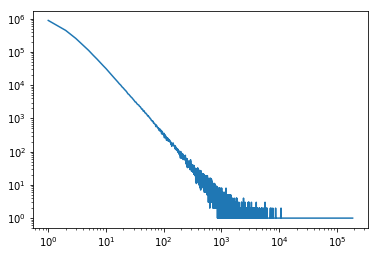

In [321]:
plt.plot(sizes, cnts)
plt.xscale('log')
plt.yscale('log')
plt.show()

Выглядит вполне ожидаемо, в середине чистый закон Ципфа, по краям есть артефакты: единица немного выбивается с прямой и  на длинном хвосте прямая зашумляется

Займемся бонусным заданием. Для начала построим симхеш

Функции для вытаскивания текста из html

In [20]:
# https://www.quora.com/How-can-I-extract-only-text-data-from-HTML-pages

def informative(element):
    if element.parent.name in ['style', 'script', '[document]', 'head', 'title']:
        return False
    elif re.match('<!--.*-->', str(element.encode('utf-8'))):
        return False
    elif len(element) < 10:
        return False
    return True


def get_text(html):
    soup = BeautifulSoup(html)
    data = soup.findAll(text=True)

    text = []
    informative_lines = [line for line in data if informative(line)]
    started = False
    for line in data:
        if line.strip() == 'Jump to search':
            started = True
            continue
        if started and informative(line):
            if re.search(r'Cached time: \d+\nCache expiry: \d+', line) is not None:
                break
            text.append(line.strip())
    
    return text


def get_words(string):
    return [word for word in re.split('[,.!?;:() \t\n]', str(string).lower()) if word]

In [72]:
DIM = 64

In [3]:
file_storage = FileStorage('../filtered_storage')
len(file_storage)

157154

Функции для подсчета симхеша. Хешируем слово, приводим биты к 1 и -1, складываем полученные вектора для всех слов из текста

Тут же определим функции для смены формата симшеха, он может быть в форматах:
- сыром: сумма 1 и -1 по всем словам из текста,
- бинарном: np.array из 0 и 1, 0 если сумма меньше 0, 1 иначе
- числовом: число, составленное из битов бинарного формата

In [91]:
def number_to_hash(value):
    result = []
    for i in range(DIM):
        result.append(value % 2)
        value = value // 2
    return np.array(result)


def calc_word_hash(word):
    value = hash(word)
    return number_to_hash(value)


def calc_simhash(text):
    hashes = np.vstack([
        calc_word_hash(word)
        for part in text
        for word in get_words(part)
    ])
    hashes = hashes * 2 - 1
    return np.sum(hashes, axis=0)


def to_binary(simhash):
    return (simhash > 0).astype(np.int)


def get_number(binary_simhash):
    power = 1
    result = 0
    for value in binary_simhash:
        result += power * int(value)
        power *= 2
    return result

Посмотрим как это все работает

In [64]:
calc_word_hash('joke')

array([0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0])

In [70]:
simhash = calc_simhash(get_text(file_storage.read(BEGINNING + '/wiki/Pig')))
simhash

array([ 10, -66, -32, -64, -22,  16, -54, -12,  60, -42,  58, -34,  -4,
        18,  12,  32, -26, -32, -14, -88, -50, -82, -34,  42,   0, -28,
       -24,  68, -12, -44,  60,  28,  22, -92, -78, -50,  52, -24, -14,
        16, -68,  48, -14,  -6,  42, -46,  28, -44, -42,  22, -28, -74,
       -58, -12,  46, -22, -48,  18,   2,  42, -36, -18, -20,  16])

In [71]:
to_binary(simhash)

array([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1])

In [32]:
BEGINNING = 'https://simple.wikipedia.org'

In [73]:
simhash - calc_simhash(get_text(file_storage.read(BEGINNING + '/wiki/Dog')))

array([  73,   83, -145,  119,  -31,  -69,   67,  141,   71, -129, -113,
        189, -211,  161,  -47,   61,   69,  -35,  143,   31,   27, -111,
        107,  -77, -109,   91, -157, -205,   65,  153,  -81,  -55,  119,
         73,  163,  -69,   11,   89,   29,   83,   69, -205,   21,   99,
        -89, -159,  -77, -113,   31,  107,   39,   49,  121,   -3,  -95,
        -25,   43,  -23,   59,  -85,  -51,  207,   23,  109])

Вычисляем симхеши

In [74]:
simhashes = {
    url: calc_simhash(get_text(html))
    for url, html in tqdm.tqdm(file_storage.items(), total=len(file_storage))
}


  0%|          | 547/157154 [00:24<1:51:15, 23.46it/s]


  1%|          | 1141/157154 [00:49<1:27:32, 29.70it/s]


  1%|          | 1779/157154 [01:12<1:56:39, 22.20it/s]


  2%|▏         | 2393/157154 [01:36<1:59:28, 21.59it/s]


  2%|▏         | 3017/157154 [01:59<2:11:36, 19.52it/s]


  2%|▏         | 3641/157154 [02:22<1:39:15, 25.78it/s]


  3%|▎         | 4261/157154 [02:44<2:02:33, 20.79it/s]


  3%|▎         | 4857/157154 [03:07<2:12:44, 19.12it/s]


  3%|▎         | 5448/157154 [03:30<1:10:56, 35.64it/s]


  4%|▍         | 6078/157154 [03:54<1:31:08, 27.63it/s]


  4%|▍         | 6664/157154 [04:17<1:44:08, 24.08it/s]


  5%|▍         | 7329/157154 [04:40<1:31:33, 27.27it/s]


  5%|▌         | 7988/157154 [05:02<1:21:08, 30.64it/s]


  6%|▌         | 8653/157154 [05:24<1:01:54, 39.98it/s]


  6%|▌         | 9261/157154 [05:46<1:45:00, 23.47it/s]


  6%|▋         | 9893/157154 [06:08<56:13, 43.65it/s]


  7%|▋         | 10517/157154 [06:32<1:11:23, 34.23it/s]


  7%|▋         | 11164/157154 [06:54<1:37:59, 24.83it/s]


  8%|▊         | 11824/157154 [07:16<1:34:43, 25.57it/s]


  8%|▊         | 12479/157154 [07:37<1:23:08, 29.00it/s]


  8%|▊         | 13141/157154 [07:59<1:29:40, 26.77it/s]


  9%|▉         | 13785/157154 [08:21<1:26:30, 27.62it/s]


  9%|▉         | 14443/157154 [08:43<1:06:27, 35.79it/s]


 10%|▉         | 15103/157154 [09:05<1:00:34, 39.08it/s]


 10%|█         | 15780/157154 [09:29<1:24:27, 27.90it/s]


 10%|█         | 16441/157154 [09:51<54:39, 42.91it/s]


 11%|█         | 17059/157154 [10:12<1:43:49, 22.49it/s]


 11%|█▏        | 17728/157154 [10:33<59:27, 39.08it/s]  


 12%|█▏        | 18378/157154 [10:55<1:22:16, 28.11it/s]


 12%|█▏        | 19023/157154 [11:18<1:28:05, 26.14it/s]


 13%|█▎        | 19700/157154 [11:39<1:26:02, 26.62it/s]


 13%|█▎        | 20392/157154 [12:01<1:10:59, 32.11it/s]


 13%|█▎        | 21085/157154 [12:25<1:18:18, 28.96it/s]


 14%|█▍        | 21749/157154 [12:46<1:04:47, 34.83it/s]


 14%|█▍        | 22397/157154 [13:09<1:00:52, 36.89it/s]


 15%|█▍        | 23033/157154 [13:32<1:09:20, 32.24it/s]


 15%|█▌        | 23695/157154 [13:53<1:24:07, 26.44it/s]


 15%|█▌        | 24358/157154 [14:15<1:09:15, 31.95it/s]


 16%|█▌        | 25075/157154 [14:36<1:22:26, 26.70it/s]


 16%|█▋        | 25742/157154 [14:57<1:17:38, 28.21it/s]


 17%|█▋        | 26435/157154 [15:19<54:55, 39.66it/s]  


 17%|█▋        | 27119/157154 [15:42<48:23, 44.79it/s]


 18%|█▊        | 27843/157154 [16:03<1:15:08, 28.68it/s]


 18%|█▊        | 28554/157154 [16:25<1:07:01, 31.98it/s]


 19%|█▊        | 29303/157154 [16:47<1:17:13, 27.59it/s]


 19%|█▉        | 30029/157154 [17:09<51:28, 41.16it/s]


 20%|█▉        | 30761/157154 [17:30<1:16:59, 27.36it/s]


 20%|██        | 31546/157154 [17:52<44:28, 47.07it/s]


 21%|██        | 32307/157154 [18:13<44:46, 46.47it/s]


 21%|██        | 33033/157154 [18:34<52:51, 39.13it/s]  


 22%|██▏       | 33789/157154 [18:55<50:36, 40.62it/s]


 22%|██▏       | 34514/157154 [19:17<1:00:57, 33.53it/s]


 22%|██▏       | 35200/157154 [19:40<1:10:52, 28.68it/s]


 23%|██▎       | 35879/157154 [20:03<1:10:38, 28.61it/s]


 23%|██▎       | 36562/157154 [20:27<1:01:40, 32.59it/s]


 24%|██▎       | 37284/157154 [20:49<1:10:40, 28.27it/s]


 24%|██▍       | 37924/157154 [21:11<1:09:41, 28.51it/s]


 25%|██▍       | 38540/157154 [21:34<1:27:10, 22.68it/s]


 25%|██▍       | 39153/157154 [21:56<1:34:48, 20.75it/s]


 25%|██▌       | 39773/157154 [22:19<59:41, 32.77it/s]  


 26%|██▌       | 40432/157154 [22:41<1:09:56, 27.82it/s]


 26%|██▌       | 41031/157154 [23:04<1:10:20, 27.52it/s]


 27%|██▋       | 41691/157154 [23:26<1:43:34, 18.58it/s]


 27%|██▋       | 42404/157154 [23:49<49:35, 38.57it/s]


 27%|██▋       | 43097/157154 [24:11<49:44, 38.21it/s]


 28%|██▊       | 43821/157154 [24:34<1:06:26, 28.43it/s]


 28%|██▊       | 44531/157154 [24:56<1:01:44, 30.40it/s]


 29%|██▉       | 45182/157154 [25:18<2:31:25, 12.32it/s]


 29%|██▉       | 45863/157154 [25:41<41:33, 44.63it/s]


 30%|██▉       | 46581/157154 [26:03<1:15:47, 24.32it/s]


 30%|███       | 47295/157154 [26:25<43:48, 41.80it/s]


 31%|███       | 48027/157154 [26:47<45:11, 40.24it/s]


 31%|███       | 48752/157154 [27:09<1:05:40, 27.51it/s]


 31%|███▏      | 49502/157154 [27:32<49:34, 36.20it/s]


 32%|███▏      | 50243/157154 [27:54<29:30, 60.37it/s]


 32%|███▏      | 50934/157154 [28:17<1:04:13, 27.56it/s]


 33%|███▎      | 51642/157154 [28:38<43:36, 40.33it/s]


 33%|███▎      | 52365/157154 [29:01<51:43, 33.77it/s]  


 34%|███▍      | 53084/157154 [29:23<45:28, 38.15it/s]


 34%|███▍      | 53800/157154 [29:46<54:34, 31.56it/s]


 35%|███▍      | 54555/157154 [30:07<1:11:08, 24.04it/s]


 35%|███▌      | 55239/157154 [30:29<38:07, 44.55it/s]


 36%|███▌      | 55888/157154 [30:51<51:54, 32.52it/s]


 36%|███▌      | 56611/157154 [31:13<45:47, 36.60it/s]


 36%|███▋      | 57341/157154 [31:35<38:44, 42.94it/s]


 37%|███▋      | 58054/157154 [31:57<1:11:47, 23.01it/s]


 37%|███▋      | 58768/157154 [32:20<1:09:29, 23.60it/s]


 38%|███▊      | 59527/157154 [32:42<56:12, 28.95it/s]


 38%|███▊      | 60262/157154 [33:06<1:41:08, 15.97it/s]


 39%|███▉      | 61007/157154 [33:28<1:01:36, 26.01it/s]


 39%|███▉      | 61755/157154 [33:51<1:09:38, 22.83it/s]


 40%|███▉      | 62467/157154 [34:14<51:43, 30.51it/s]  


 40%|████      | 63140/157154 [34:38<32:48, 47.75it/s]


 41%|████      | 63922/157154 [34:59<55:13, 28.13it/s]  


 41%|████      | 64678/157154 [35:22<44:17, 34.80it/s]


 42%|████▏     | 65423/157154 [35:45<1:17:25, 19.75it/s]


 42%|████▏     | 66214/157154 [36:05<39:27, 38.41it/s]


 43%|████▎     | 66945/157154 [36:28<50:00, 30.06it/s]


 43%|████▎     | 67677/157154 [36:49<55:13, 27.01it/s]  


 44%|████▎     | 68399/157154 [37:12<47:19, 31.26it/s]


 44%|████▍     | 69103/157154 [37:32<36:12, 40.53it/s]


 44%|████▍     | 69847/157154 [37:54<37:11, 39.13it/s]


 45%|████▍     | 70699/157154 [38:16<38:07, 37.80it/s]


 45%|████▌     | 71491/157154 [38:37<32:54, 43.38it/s]


 46%|████▌     | 72327/157154 [38:59<41:07, 34.38it/s]


 47%|████▋     | 73119/157154 [39:22<55:20, 25.31it/s]


 47%|████▋     | 73894/157154 [39:44<39:22, 35.24it/s]


 48%|████▊     | 74681/157154 [40:04<33:09, 41.46it/s]


 48%|████▊     | 75527/157154 [40:25<35:39, 38.16it/s]


 49%|████▊     | 76322/157154 [40:46<36:01, 37.40it/s]


 49%|████▉     | 77143/157154 [41:08<32:49, 40.63it/s]


 50%|████▉     | 77943/157154 [41:31<34:40, 38.07it/s]


 50%|█████     | 78703/157154 [41:52<34:57, 37.41it/s]


 51%|█████     | 79481/157154 [42:13<31:29, 41.10it/s]


 51%|█████     | 80308/157154 [42:34<40:16, 31.80it/s]


 52%|█████▏    | 81108/157154 [42:57<35:28, 35.73it/s]


 52%|█████▏    | 81939/157154 [43:18<26:09, 47.93it/s]


 53%|█████▎    | 82758/157154 [43:39<40:03, 30.95it/s]


 53%|█████▎    | 83549/157154 [44:01<26:51, 45.67it/s]


 54%|█████▎    | 84381/157154 [44:22<26:09, 46.37it/s]


 54%|█████▍    | 85235/157154 [44:42<29:45, 40.28it/s]


 55%|█████▍    | 86051/157154 [45:03<24:16, 48.83it/s]


 55%|█████▌    | 86877/157154 [45:24<38:34, 30.37it/s]


 56%|█████▌    | 87660/157154 [45:46<30:13, 38.33it/s]


 56%|█████▋    | 88472/157154 [46:06<40:21, 28.37it/s]


 57%|█████▋    | 89209/157154 [46:28<34:26, 32.88it/s]


 57%|█████▋    | 90030/157154 [46:49<31:25, 35.60it/s]


 58%|█████▊    | 90845/157154 [47:08<27:48, 39.74it/s]


 58%|█████▊    | 91646/157154 [47:30<34:57, 31.23it/s]


 59%|█████▉    | 92447/157154 [47:51<20:45, 51.95it/s]


 59%|█████▉    | 93290/157154 [48:11<47:44, 22.29it/s]


 60%|█████▉    | 94140/157154 [48:33<20:16, 51.81it/s]


 60%|██████    | 94987/157154 [48:53<28:33, 36.28it/s]


 61%|██████    | 95809/157154 [49:13<36:11, 28.25it/s]


 61%|██████▏   | 96597/157154 [49:34<17:14, 58.52it/s]


 62%|██████▏   | 97414/157154 [49:54<35:02, 28.42it/s]


 62%|██████▏   | 98206/157154 [50:15<23:42, 41.44it/s]


 63%|██████▎   | 99038/157154 [50:36<19:45, 49.02it/s]


 64%|██████▎   | 99868/157154 [50:55<19:42, 48.46it/s]


 64%|██████▍   | 100684/157154 [51:16<31:17, 30.07it/s]


 65%|██████▍   | 101480/157154 [51:35<15:37, 59.39it/s]


 65%|██████▌   | 102234/157154 [51:56<44:13, 20.70it/s]


 66%|██████▌   | 103027/157154 [52:16<30:54, 29.18it/s]


 66%|██████▌   | 103831/157154 [52:36<32:39, 27.21it/s]


 67%|██████▋   | 104599/157154 [52:55<20:13, 43.32it/s]


 67%|██████▋   | 105395/157154 [53:15<20:41, 41.70it/s]


 68%|██████▊   | 106151/157154 [53:35<20:40, 41.10it/s]


 68%|██████▊   | 106894/157154 [53:55<26:48, 31.25it/s]


 68%|██████▊   | 107627/157154 [54:14<16:01, 51.52it/s]


 69%|██████▉   | 108370/157154 [54:35<23:12, 35.04it/s]


 69%|██████▉   | 109093/157154 [54:56<20:31, 39.01it/s]


 70%|██████▉   | 109784/157154 [55:15<19:53, 39.70it/s]


 70%|███████   | 110518/157154 [55:36<17:12, 45.15it/s]


 71%|███████   | 111241/157154 [55:57<25:37, 29.87it/s]


 71%|███████   | 111944/157154 [56:18<23:32, 32.02it/s]


 72%|███████▏  | 112678/157154 [56:37<19:52, 37.31it/s]


 72%|███████▏  | 113431/157154 [56:56<21:13, 34.34it/s]


 73%|███████▎  | 114190/157154 [57:16<24:33, 29.16it/s]


 73%|███████▎  | 114990/157154 [57:35<16:58, 41.39it/s]


 74%|███████▎  | 115775/157154 [57:54<14:56, 46.14it/s]


 74%|███████▍  | 116606/157154 [58:13<22:21, 30.23it/s]


 75%|███████▍  | 117391/157154 [58:33<16:28, 40.23it/s]


 75%|███████▌  | 118162/157154 [58:53<17:44, 36.62it/s]


 76%|███████▌  | 118961/157154 [59:12<20:49, 30.57it/s]


 76%|███████▌  | 119749/157154 [59:31<17:02, 36.58it/s]


 77%|███████▋  | 120555/157154 [59:50<12:12, 49.95it/s]


 77%|███████▋  | 121348/157154 [1:00:10<13:37, 43.79it/s]


 78%|███████▊  | 122098/157154 [1:00:29<12:12, 47.85it/s]


 78%|███████▊  | 122883/157154 [1:00:48<19:03, 29.96it/s]


 79%|███████▊  | 123672/157154 [1:01:07<10:42, 52.11it/s]


 79%|███████▉  | 124467/157154 [1:01:26<13:51, 39.32it/s]


 80%|███████▉  | 125265/157154 [1:01:44<10:16, 51.73it/s]


 80%|████████  | 126040/157154 [1:02:02<10:26, 49.66it/s]


 81%|████████  | 126834/157154 [1:02:21<16:45, 30.14it/s]


 81%|████████  | 127614/157154 [1:02:39<09:06, 54.10it/s]


 82%|████████▏ | 128404/157154 [1:02:58<09:29, 50.44it/s]


 82%|████████▏ | 129193/157154 [1:03:16<09:57, 46.76it/s]


 83%|████████▎ | 129998/157154 [1:03:35<11:32, 39.22it/s]


 83%|████████▎ | 130822/157154 [1:03:54<09:11, 47.78it/s]


 84%|████████▎ | 131610/157154 [1:04:13<10:05, 42.18it/s]


 84%|████████▍ | 132409/157154 [1:04:31<08:14, 50.08it/s]


 85%|████████▍ | 133214/157154 [1:04:49<07:04, 56.41it/s]


 85%|████████▌ | 134023/157154 [1:05:08<08:39, 44.56it/s]


 86%|████████▌ | 134856/157154 [1:05:26<10:45, 34.57it/s]


 86%|████████▋ | 135675/157154 [1:05:44<07:06, 50.32it/s]


 87%|████████▋ | 136520/157154 [1:06:01<07:45, 44.31it/s]


 87%|████████▋ | 137350/157154 [1:06:19<06:42, 49.20it/s]


 88%|████████▊ | 138195/157154 [1:06:38<05:58, 52.88it/s]


 88%|████████▊ | 139037/157154 [1:06:55<05:54, 51.10it/s]


 89%|████████▉ | 139879/157154 [1:07:13<09:57, 28.89it/s]


 90%|████████▉ | 140718/157154 [1:07:31<05:07, 53.37it/s]


 90%|█████████ | 141541/157154 [1:07:49<09:17, 28.03it/s]


 91%|█████████ | 142370/157154 [1:08:07<04:21, 56.52it/s]


 91%|█████████ | 143230/157154 [1:08:25<06:46, 34.21it/s]


 92%|█████████▏| 144075/157154 [1:08:42<05:45, 37.90it/s]


 92%|█████████▏| 144950/157154 [1:09:00<03:10, 64.03it/s]


 93%|█████████▎| 145933/157154 [1:09:18<03:09, 59.30it/s]


 93%|█████████▎| 146921/157154 [1:09:35<02:35, 65.80it/s]


 94%|█████████▍| 147889/157154 [1:09:53<03:34, 43.10it/s]


 95%|█████████▍| 148842/157154 [1:10:10<02:59, 46.26it/s]


 95%|█████████▌| 149851/157154 [1:10:27<02:17, 53.04it/s]


 96%|█████████▌| 150915/157154 [1:10:44<01:23, 74.72it/s]


 97%|█████████▋| 152032/157154 [1:11:00<01:14, 68.43it/s]


 97%|█████████▋| 153217/157154 [1:11:16<00:48, 80.81it/s]


 98%|█████████▊| 154449/157154 [1:11:33<00:30, 88.51it/s]


 99%|█████████▉| 155537/157154 [1:11:49<00:23, 67.96it/s]


100%|█████████▉| 156600/157154 [1:12:05<00:08, 67.32it/s]


100%|██████████| 157154/157154 [1:12:15<00:00, 36.25it/s]

Дампим их

In [75]:
with open('simhashes.pkl', 'wb') as simhashes_pkl:
    pickle.dump(simhashes, simhashes_pkl)

In [78]:
with open('simhashes.pkl', 'rb') as simhashes_pkl:
    simhashes = pickle.load(simhashes_pkl)

In [80]:
with open('wiki_simhashes_with_urls.txt', 'w') as with_urls_file:
    for url, simhash in simhashes.items():
        with_urls_file.write(','.join(map(str, simhash)) + ' ' + url + '\n')

In [ ]:
with open('wiki_simhash.txt', 'w') as binary_simhash_file:
    for simhash in simhashes.values():
        binary_simhash_file.write(str(get_number(to_binary(simhash))) + '\n')

Плюсовым кодом (calc_group_sizes.cpp) посчитаем размеры групп. Там почти такой же код, что и в calc_group_stats.cpp, только найденная группа не удаляется

In [116]:
with open('group_sizes.txt') as group_sizes_file:
    number_simhash_exact_group_size = {}
    for line in group_sizes_file:
        simhash_number, group_size = map(int, line.split(' ', 1))
        number_simhash_exact_group_size[simhash_number] = group_size

url_group_size = {}
for url, simhash in simhashes.items():
    url_group_size[url] = number_simhash_exact_group_size[get_number(to_binary(simhash))]

Построим для интереса тут тоже график количеств групп разных размеров

In [142]:
group_size_counter = Counter(number_simhash_exact_group_size.values())
group_size_counts = np.array(list(sorted(group_size_counter.items(), key=lambda x: -x[0])))
group_sizes = group_size_counts[:, 0]
counts = group_size_counts[:, 1]

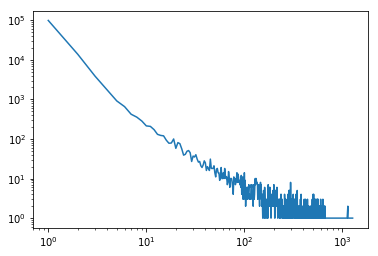

In [144]:
plt.plot(group_sizes, counts)
plt.xscale('log')
plt.yscale('log')
plt.show()

Похожая картина, может у меня пока все правильно? :)

Посчитаем дисперсию значений симхешей для каждой координаты

In [94]:
simhash_array = np.vstack(simhashes.values())

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [95]:
simhash_array.shape

(157154, 64)

In [164]:
simhash_mean = np.mean(simhash_array, axis=0)
simhash_std = np.sqrt(np.mean(simhash_array ** 2, axis=0) - mean ** 2)
simhash_mean, simhash_std

(array([  4.29961057, -24.08342772,   2.85262227, -34.15648981,
        -12.89127226,  32.45592858,  -9.16600914,  26.55917762,
         -4.3291103 , -12.71530473,  50.4254871 , -55.26717106,
         21.93036766, -39.79143388,  -2.66143401,  -1.1892984 ,
         -9.9499281 , -46.82345343, -27.7366214 , -21.74591165,
         -9.41589142,  17.26981814, -16.73168357,  37.81936826,
         15.74714611,   9.5093157 ,  27.38170839,  16.93311656,
         14.64869491, -34.58067246,  33.72946918,  28.97586444,
         19.68366698, -46.40912099, -46.33823511, -12.52535093,
         49.29053667,  -5.10858775,  -9.00849485,   9.54529315,
        -27.34676178,  13.72589307, -12.34898889, -22.37936674,
          5.15150108,  -2.15125927,  57.32778676, -13.90319686,
         -7.76479759,   7.22773203,   8.92764422, -27.28685875,
          1.07824809,  20.15767336,  38.72277511,  19.50520509,
        -30.52486733,  10.6804472 , -28.79985874,   6.56960052,
        -10.28202273, -39.4015488 , -18.

In [ ]:
alpha = 0.05
duplicate_addition_std = simhash_std * np.sqrt(alpha)

Нормальное распределение симметричное и масштабируемое, поэтому что бы посчитать нужную вероятность, можно вычислить $P(value \cdot sigma < \epsilon)$, где $value$ - значение координаты симхеша, $sigma$ - корень из дисперсии разности между дублем и полудублем ($\widetilde{X} - X$ из презентации), a $\epsilon\sim N(0, 1)$

In [166]:
ss.norm.cdf(np.array([1, 2]))

array([0.84134475, 0.97724987])

In [167]:
ss.norm(0, 2).cdf(np.array([2, 4]))

array([0.84134475, 0.97724987])

In [168]:
duplicate_addition_std

array([11.44998778, 16.93589194, 11.96196071, 17.20344259, 12.32684882,
       18.81782267, 13.86523408, 15.90300293, 12.30374882, 11.43717088,
       25.37595217, 24.48093087, 16.53480433, 20.85938322, 11.2316916 ,
       13.06775384, 12.85471027, 21.76457457, 19.06121242, 13.99073053,
       13.63551651, 13.02369908, 13.03576939, 19.41902234, 12.08008723,
       11.68329175, 17.97334404, 17.15348733, 12.55776069, 19.55969654,
       20.74532737, 17.89072998, 13.01473714, 23.4046159 , 23.95691046,
       14.34619573, 22.40502288, 12.43637305, 11.82210116, 12.94007206,
       17.33404826, 12.23457422, 12.06391007, 15.58106324, 12.98696482,
       11.1329593 , 28.13812253, 13.0470622 , 12.57626557, 12.87536061,
       12.2850583 , 20.43857923, 11.69980211, 12.99105515, 20.07399841,
       16.0063495 , 16.25932921, 13.0161844 , 16.18518235, 14.47983719,
       12.63280185, 21.73806509, 13.39537797, 19.60427492])

In [160]:
simhashes[BEGINNING + '/wiki/Germany']

array([ 113,  -43, -205, -243, -159,  377, -377,  273,  109,  -55,  605,
       -967,   99, -451,   17, -265, -265, -355, -685, -421, -261,  443,
       -287,  641,  121,   89,  159,  -47,  211, -369,  349,  315,  311,
       -659, -749, -457,  755, -305,  -31,  221, -335, -125,   37, -181,
        209,  111,  573, -159,  -97,   11,  -83, -403,   75,   97,  607,
        223,  -47,   49, -399,  413, -113, -325, -323, -455])

In [169]:
def calc_change_ind_probas(simhash, sqrt_alpha=0.2):
    return ss.norm.cdf(-np.abs(simhash / duplicate_addition_var))

calc_change_ind_probas(simhashes[BEGINNING + '/wiki/Germany'])

array([2.83619091e-023, 5.55870658e-003, 3.88588308e-066, 1.33049072e-045,
       2.28955350e-038, 1.38632649e-089, 4.22816899e-163, 2.36268815e-066,
       4.03356451e-019, 7.58885529e-007, 6.20751952e-126, 0.00000000e+000,
       1.06630294e-009, 5.70333046e-104, 6.50669189e-002, 9.86991415e-092,
       1.00637192e-094, 4.12773563e-060, 4.06081529e-283, 3.14375236e-199,
       5.73120269e-082, 6.70489018e-254, 1.00410726e-107, 3.02959877e-239,
       6.45055337e-024, 1.29101675e-014, 4.51802057e-019, 3.07226179e-003,
       1.17264542e-063, 1.09960969e-079, 8.26879148e-064, 1.09064365e-069,
       1.68575321e-126, 9.88102141e-175, 7.09899429e-215, 5.58758179e-223,
       3.11287181e-249, 4.01390803e-133, 4.36811368e-003, 1.06859633e-065,
       1.61920346e-083, 8.32509449e-025, 1.08109794e-003, 1.69557507e-031,
       1.42689256e-058, 1.02705296e-023, 1.75050730e-092, 1.83079915e-034,
       6.14752515e-015, 1.96456929e-001, 7.08412886e-012, 7.61226629e-087,
       7.25859060e-011, 4

In [171]:
ss.norm(0, 11.44998778).cdf(-113)

2.8361910147503024e-23

Пришло время алгоритма вероятностного поиска

Node - нода в дереве, которое строится в алгоритме

NodeHeap - куча над Node c приоритетом по вероятности

Node умеет возвращать своих детей: левого и правого. Левый - прибавление 1 к максимальному индексу, правый - прибавление 1 к первому в максимальной паре индексов, отличающихся на 2.

In [258]:
class Node:
    def __init__(self, indexes):
        self._indexes = indexes
    
    def build_children(self):
        left, right = [], []
        if self._indexes[-1] < DIM - 1:
            new_inds = copy(self._indexes)
            new_inds[-1] += 1
            left = [Node(new_inds)]
        max_j = None
        for j in range(len(self._indexes) - 1):
            if self._indexes[j + 1] - self._indexes[j] == 2:
                max_j = j
        
        if max_j is not None:
            new_inds = copy(self._indexes)
            new_inds[max_j] += 1
            right = [Node(new_inds)]
        return left + right
                 
    def calc_log_proba(self, log_probas, sorted_indexes):
        return np.sum(log_probas[sorted_indexes[self._indexes]])
    
    @property
    def indexes(self):
        return self._indexes
    
    def __str__(self):
        return str(self._indexes)
    
    def __repr__(self):
        return repr(self._indexes)
    
    def __hash__(self):
        return hash(tuple(self._indexes))
    
    def __eq__(self, other_node):
        return self._indexes == other_node.indexes
    
    
class NodeHeap:
    def __init__(self, log_probas, sorted_indexes):
        self._heap = []
        self._counter = count()
        self._log_probas = log_probas
        self._sorted_indexes = sorted_indexes
        self._nodes_was_in_heap = set()
        
    def push(self, node):
        if node not in self._nodes_was_in_heap:
            log_proba = node.calc_log_proba(self._log_probas, self._sorted_indexes)
            heappush(self._heap, (-log_proba, next(self._counter), node))
            self._nodes_was_in_heap.add(node)
        
    def pop(self):
        return heappop(self._heap)[2]

In [259]:
a = Node([0, 1, 2]).build_children()
print(a)
a[0].build_children()

[[0, 1, 3]]


[[0, 1, 4], [0, 2, 3]]

Чтобы получить кандидата на дубликат мы создаем кучу из трех нод, по одной ноде каждого размера 1, 2, 3. Дальше в цикле достаем из кучи самую вероятную ноду, кладем в кучу её детей и так продолжаем пока хватает терпения

In [269]:
def get_indexes(simhash, max_num_steps=100):
    log_probas = np.log(calc_change_ind_probas(simhash) + 1e-300)
    sorted_indexes = np.argsort(-log_probas)
    heap = NodeHeap(log_probas, sorted_indexes)
    for node in [Node([0]), Node([0, 1]), Node([0, 1, 2])]:
        heap.push(node)
        
    indexes = []
    for step in range(max_num_steps):
        node = heap.pop()
        for new_node in node.build_children():
            heap.push(new_node)
        yield sorted_indexes[node.indexes]

In [272]:
[i for i in get_indexes(simhashes[BEGINNING + '/wiki/Germany'], 20)]

[array([49]),
 array([14]),
 array([49, 14]),
 array([1]),
 array([38]),
 array([27]),
 array([56]),
 array([49,  1]),
 array([42]),
 array([49, 38]),
 array([49, 27]),
 array([49, 56]),
 array([14,  1]),
 array([14, 38]),
 array([49, 42]),
 array([14, 27]),
 array([14, 56]),
 array([57]),
 array([49, 14,  1]),
 array([14, 42])]

Посчитаем наконец дубликаты вероятностым алгоритмом

In [278]:
all_bin_simhashes_counter = Counter((
    get_number(to_binary(simhash)) for simhash in simhashes.values()
))

In [284]:
def get_duplicate_cnts_by_step(url, max_query_num=10000):
    real_group_size = url_group_size[url]
    simhash = simhashes[url]
    bin_simhash = to_binary(simhash)
    exact_duplicate_cnt = all_bin_simhashes_counter[get_number(bin_simhash)]
    if real_group_size == exact_duplicate_cnt:
        return []

    candidates_inds_generator = get_indexes(simhash, max_num_steps=max_query_num)
    found_duplicates = []
    total_group_size = exact_duplicate_cnt
    for step, inds in enumerate(candidates_inds_generator):
        new_simhash = deepcopy(bin_simhash)
        new_simhash[inds] = 1 - bin_simhash[inds]
        duplicates_cnt = all_bin_simhashes_counter.get(get_number(new_simhash))
        if duplicates_cnt is not None:
            found_duplicates.append((duplicates_cnt, step))
            total_group_size += duplicates_cnt
            if total_group_size >= real_group_size:
                return found_duplicates
    return found_duplicates

In [297]:
duplicate_cnt_by_step = defaultdict(int)
for url in tqdm.tqdm(simhashes.keys(), total=len(simhashes)):
    found_duplicates = get_duplicate_cnts_by_step(url, 10000)
    for duplicates_cnt, step in found_duplicates:
        duplicate_cnt_by_step[step] += duplicates_cnt



  0%|          | 0/157154 [00:00<?, ?it/s]

  0%|          | 17/157154 [00:00<1:15:38, 34.62it/s]

  0%|          | 21/157154 [00:00<2:28:51, 17.59it/s]

  0%|          | 27/157154 [00:01<2:05:18, 20.90it/s]

  0%|          | 29/157154 [00:01<4:43:07,  9.25it/s]

  0%|          | 32/157154 [00:02<6:22:23,  6.85it/s]

  0%|          | 35/157154 [00:02<6:39:01,  6.56it/s]

  0%|          | 48/157154 [00:03<4:52:43,  8.94it/s]

  0%|          | 53/157154 [00:03<3:44:16, 11.68it/s]

  0%|          | 61/157154 [00:03<3:32:30, 12.32it/s]

  0%|          | 67/157154 [00:04<3:36:48, 12.08it/s]

  0%|          | 71/157154 [00:04<4:10:26, 10.45it/s]

  0%|          | 86/157154 [00:05<3:14:44, 13.44it/s]

  0%|          | 89/157154 [00:05<4:13:03, 10.34it/s]

  0%|          | 109/157154 [00:06<3:16:10, 13.34it/s]

  0%|          | 121/157154 [00:06<2:25:02, 18.04it/s]

  0%|          | 128/157154 [00:06<2:37:24, 16.63it/s]

  0%|          | 136/157154 [00:07<2:37:33, 16.61it/s]

  0%|          

  1%|          | 1247/157154 [00:53<2:37:31, 16.50it/s]

  1%|          | 1257/157154 [00:54<2:28:48, 17.46it/s]

  1%|          | 1263/157154 [00:54<1:59:52, 21.67it/s]

  1%|          | 1267/157154 [00:55<3:22:20, 12.84it/s]

  1%|          | 1280/157154 [00:55<2:51:28, 15.15it/s]

  1%|          | 1291/157154 [00:56<2:35:27, 16.71it/s]

  1%|          | 1302/157154 [00:56<2:24:09, 18.02it/s]

  1%|          | 1305/157154 [00:57<4:45:54,  9.09it/s]

  1%|          | 1307/157154 [00:57<6:36:43,  6.55it/s]

  1%|          | 1311/157154 [00:58<6:14:17,  6.94it/s]

  1%|          | 1316/157154 [00:58<5:40:39,  7.62it/s]

  1%|          | 1335/157154 [00:59<4:18:41, 10.04it/s]

  1%|          | 1347/157154 [00:59<3:26:36, 12.57it/s]

  1%|          | 1361/157154 [01:00<3:04:01, 14.11it/s]

  1%|          | 1390/157154 [01:00<2:18:23, 18.76it/s]

  1%|          | 1400/157154 [01:01<2:15:40, 19.13it/s]

  1%|          | 1409/157154 [01:01<2:23:13, 18.12it/s]

  1%|          | 1416/157154 [0

  2%|▏         | 2536/157154 [01:41<4:15:28, 10.09it/s]

  2%|▏         | 2547/157154 [01:41<3:07:16, 13.76it/s]

  2%|▏         | 2552/157154 [01:42<2:40:39, 16.04it/s]

  2%|▏         | 2557/157154 [01:42<2:18:23, 18.62it/s]

  2%|▏         | 2569/157154 [01:42<1:44:01, 24.77it/s]

  2%|▏         | 2575/157154 [01:42<1:34:13, 27.34it/s]

  2%|▏         | 2635/157154 [01:43<1:11:24, 36.06it/s]

  2%|▏         | 2663/157154 [01:43<59:30, 43.27it/s]  

  2%|▏         | 2671/157154 [01:44<1:47:40, 23.91it/s]

  2%|▏         | 2677/157154 [01:44<2:18:27, 18.60it/s]

  2%|▏         | 2689/157154 [01:45<2:22:14, 18.10it/s]

  2%|▏         | 2703/157154 [01:45<1:47:24, 23.97it/s]

  2%|▏         | 2709/157154 [01:45<2:19:31, 18.45it/s]

  2%|▏         | 2732/157154 [01:46<1:44:01, 24.74it/s]

  2%|▏         | 2747/157154 [01:46<1:36:14, 26.74it/s]

  2%|▏         | 2763/157154 [01:46<1:12:36, 35.44it/s]

  2%|▏         | 2779/157154 [01:46<56:34, 45.48it/s]  

  2%|▏         | 2789/157154 [0

  3%|▎         | 4096/157154 [02:35<2:09:07, 19.76it/s]

  3%|▎         | 4102/157154 [02:35<2:39:32, 15.99it/s]

  3%|▎         | 4105/157154 [02:36<4:10:38, 10.18it/s]

  3%|▎         | 4135/157154 [02:36<3:09:12, 13.48it/s]

  3%|▎         | 4151/157154 [02:37<2:18:59, 18.35it/s]

  3%|▎         | 4157/157154 [02:37<2:12:29, 19.25it/s]

  3%|▎         | 4171/157154 [02:38<2:13:47, 19.06it/s]

  3%|▎         | 4175/157154 [02:39<4:56:14,  8.61it/s]

  3%|▎         | 4178/157154 [02:39<5:44:28,  7.40it/s]

  3%|▎         | 4191/157154 [02:40<4:31:57,  9.37it/s]

  3%|▎         | 4194/157154 [02:40<5:23:47,  7.87it/s]

  3%|▎         | 4201/157154 [02:41<4:33:59,  9.30it/s]

  3%|▎         | 4203/157154 [02:41<7:54:25,  5.37it/s]

  3%|▎         | 4206/157154 [02:42<7:46:19,  5.47it/s]

  3%|▎         | 4208/157154 [02:42<8:55:10,  4.76it/s]

  3%|▎         | 4214/157154 [02:43<6:44:36,  6.30it/s]

  3%|▎         | 4220/157154 [02:43<5:50:50,  7.26it/s]

  3%|▎         | 4234/157154 [0

  4%|▎         | 5597/157154 [03:34<3:58:25, 10.59it/s]

  4%|▎         | 5600/157154 [03:34<3:28:33, 12.11it/s]

  4%|▎         | 5614/157154 [03:35<2:31:27, 16.67it/s]

  4%|▎         | 5620/157154 [03:35<3:15:05, 12.95it/s]

  4%|▎         | 5625/157154 [03:36<3:39:46, 11.49it/s]

  4%|▎         | 5666/157154 [03:36<2:36:05, 16.17it/s]

  4%|▎         | 5679/157154 [03:36<1:58:28, 21.31it/s]

  4%|▎         | 5690/157154 [03:36<1:40:39, 25.08it/s]

  4%|▎         | 5699/157154 [03:37<1:29:22, 28.24it/s]

  4%|▎         | 5707/157154 [03:37<1:14:01, 34.10it/s]

  4%|▎         | 5715/157154 [03:37<1:02:50, 40.17it/s]

  4%|▎         | 5723/157154 [03:37<1:03:28, 39.76it/s]

  4%|▎         | 5730/157154 [03:37<55:51, 45.18it/s]  

  4%|▎         | 5739/157154 [03:38<1:30:39, 27.83it/s]

  4%|▎         | 5744/157154 [03:38<2:42:50, 15.50it/s]

  4%|▎         | 5749/157154 [03:38<2:11:19, 19.22it/s]

  4%|▎         | 5775/157154 [03:39<1:44:45, 24.08it/s]

  4%|▎         | 5780/157154 [0

  4%|▍         | 7022/157154 [04:25<1:28:06, 28.40it/s]

  4%|▍         | 7033/157154 [04:25<1:13:10, 34.19it/s]

  5%|▍         | 7072/157154 [04:25<1:02:30, 40.01it/s]

  5%|▍         | 7107/157154 [04:26<47:54, 52.20it/s]  

  5%|▍         | 7119/157154 [04:27<1:49:35, 22.82it/s]

  5%|▍         | 7129/157154 [04:27<1:59:58, 20.84it/s]

  5%|▍         | 7136/157154 [04:29<3:28:18, 12.00it/s]

  5%|▍         | 7148/157154 [04:29<2:58:48, 13.98it/s]

  5%|▍         | 7155/157154 [04:29<2:17:50, 18.14it/s]

  5%|▍         | 7167/157154 [04:29<1:49:48, 22.77it/s]

  5%|▍         | 7207/157154 [04:30<1:31:11, 27.41it/s]

  5%|▍         | 7225/157154 [04:30<1:09:38, 35.88it/s]

  5%|▍         | 7233/157154 [04:31<1:40:19, 24.91it/s]

  5%|▍         | 7254/157154 [04:31<1:16:03, 32.85it/s]

  5%|▍         | 7262/157154 [04:31<1:22:40, 30.22it/s]

  5%|▍         | 7269/157154 [04:32<1:54:53, 21.74it/s]

  5%|▍         | 7274/157154 [04:33<3:19:00, 12.55it/s]

  5%|▍         | 7278/157154 [0

  6%|▌         | 8764/157154 [05:23<1:37:12, 25.44it/s]

  6%|▌         | 8772/157154 [05:23<1:24:11, 29.38it/s]

  6%|▌         | 8780/157154 [05:23<1:23:01, 29.79it/s]

  6%|▌         | 8817/157154 [05:24<1:03:09, 39.14it/s]

  6%|▌         | 8840/157154 [05:24<1:01:42, 40.06it/s]

  6%|▌         | 8853/157154 [05:24<49:21, 50.08it/s]  

  6%|▌         | 8870/157154 [05:25<1:06:55, 36.93it/s]

  6%|▌         | 8877/157154 [05:25<1:15:57, 32.53it/s]

  6%|▌         | 8883/157154 [05:26<2:12:14, 18.69it/s]

  6%|▌         | 8888/157154 [05:26<1:53:02, 21.86it/s]

  6%|▌         | 8897/157154 [05:26<1:29:15, 27.68it/s]

  6%|▌         | 8919/157154 [05:26<1:07:02, 36.85it/s]

  6%|▌         | 8928/157154 [05:27<1:25:04, 29.04it/s]

  6%|▌         | 8948/157154 [05:27<1:04:28, 38.31it/s]

  6%|▌         | 8994/157154 [05:27<47:00, 52.53it/s]  

  6%|▌         | 9013/157154 [05:28<53:52, 45.83it/s]

  6%|▌         | 9027/157154 [05:28<53:17, 46.33it/s]

  6%|▌         | 9039/157154 [05:28

  7%|▋         | 10343/157154 [06:16<3:15:03, 12.54it/s]

  7%|▋         | 10351/157154 [06:16<2:26:23, 16.71it/s]

  7%|▋         | 10358/157154 [06:16<2:08:59, 18.97it/s]

  7%|▋         | 10362/157154 [06:17<3:20:32, 12.20it/s]

  7%|▋         | 10367/157154 [06:17<3:04:58, 13.23it/s]

  7%|▋         | 10372/157154 [06:18<3:35:32, 11.35it/s]

  7%|▋         | 10375/157154 [06:19<4:53:01,  8.35it/s]

  7%|▋         | 10379/157154 [06:19<4:03:06, 10.06it/s]

  7%|▋         | 10381/157154 [06:19<3:29:26, 11.68it/s]

  7%|▋         | 10384/157154 [06:19<2:59:51, 13.60it/s]

  7%|▋         | 10392/157154 [06:19<2:25:00, 16.87it/s]

  7%|▋         | 10395/157154 [06:20<3:57:05, 10.32it/s]

  7%|▋         | 10400/157154 [06:20<3:16:21, 12.46it/s]

  7%|▋         | 10406/157154 [06:21<3:51:52, 10.55it/s]

  7%|▋         | 10414/157154 [06:21<2:53:35, 14.09it/s]

  7%|▋         | 10425/157154 [06:21<2:35:55, 15.68it/s]

  7%|▋         | 10453/157154 [06:22<2:01:58, 20.05it/s]

  7%|▋        

  7%|▋         | 11773/157154 [07:07<1:07:40, 35.80it/s]

  7%|▋         | 11780/157154 [07:07<1:17:12, 31.38it/s]

  8%|▊         | 11795/157154 [07:08<1:09:26, 34.89it/s]

  8%|▊         | 11801/157154 [07:09<2:18:32, 17.49it/s]

  8%|▊         | 11811/157154 [07:09<2:14:46, 17.97it/s]

  8%|▊         | 11814/157154 [07:09<2:14:20, 18.03it/s]

  8%|▊         | 11821/157154 [07:10<2:34:00, 15.73it/s]

  8%|▊         | 11832/157154 [07:10<1:59:49, 20.21it/s]

  8%|▊         | 11838/157154 [07:10<2:22:33, 16.99it/s]

  8%|▊         | 11841/157154 [07:11<2:39:10, 15.22it/s]

  8%|▊         | 11856/157154 [07:11<1:58:29, 20.44it/s]

  8%|▊         | 11861/157154 [07:11<1:40:56, 23.99it/s]

  8%|▊         | 11875/157154 [07:12<1:54:22, 21.17it/s]

  8%|▊         | 11879/157154 [07:12<2:48:50, 14.34it/s]

  8%|▊         | 11897/157154 [07:13<2:06:01, 19.21it/s]

  8%|▊         | 11920/157154 [07:13<1:42:03, 23.72it/s]

  8%|▊         | 11930/157154 [07:14<1:55:31, 20.95it/s]

  8%|▊        

  8%|▊         | 13265/157154 [08:04<4:35:13,  8.71it/s]

  8%|▊         | 13283/157154 [08:04<3:31:39, 11.33it/s]

  8%|▊         | 13286/157154 [08:05<3:36:54, 11.05it/s]

  8%|▊         | 13313/157154 [08:05<2:42:31, 14.75it/s]

  8%|▊         | 13338/157154 [08:06<2:08:41, 18.63it/s]

  8%|▊         | 13342/157154 [08:06<3:51:35, 10.35it/s]

  8%|▊         | 13348/157154 [08:07<2:57:22, 13.51it/s]

  9%|▊         | 13362/157154 [08:07<2:14:35, 17.81it/s]

  9%|▊         | 13375/157154 [08:07<2:02:41, 19.53it/s]

  9%|▊         | 13382/157154 [08:07<1:43:45, 23.09it/s]

  9%|▊         | 13386/157154 [08:08<1:45:25, 22.73it/s]

  9%|▊         | 13390/157154 [08:08<2:52:26, 13.89it/s]

  9%|▊         | 13393/157154 [08:09<3:59:58,  9.98it/s]

  9%|▊         | 13396/157154 [08:09<3:18:50, 12.05it/s]

  9%|▊         | 13399/157154 [08:09<4:17:22,  9.31it/s]

  9%|▊         | 13403/157154 [08:10<5:17:36,  7.54it/s]

  9%|▊         | 13408/157154 [08:10<3:59:49,  9.99it/s]

  9%|▊        

  9%|▉         | 14694/157154 [08:56<1:51:13, 21.35it/s]

  9%|▉         | 14707/157154 [08:56<1:42:16, 23.21it/s]

  9%|▉         | 14712/157154 [08:56<1:33:23, 25.42it/s]

  9%|▉         | 14727/157154 [08:57<1:30:19, 26.28it/s]

  9%|▉         | 14731/157154 [08:58<3:10:10, 12.48it/s]

  9%|▉         | 14734/157154 [08:58<2:42:13, 14.63it/s]

  9%|▉         | 14743/157154 [08:58<2:03:12, 19.26it/s]

  9%|▉         | 14748/157154 [08:58<2:28:33, 15.98it/s]

  9%|▉         | 14752/157154 [08:59<3:21:38, 11.77it/s]

  9%|▉         | 14789/157154 [08:59<2:24:51, 16.38it/s]

  9%|▉         | 14797/157154 [09:01<4:17:56,  9.20it/s]

  9%|▉         | 14805/157154 [09:01<3:50:19, 10.30it/s]

  9%|▉         | 14821/157154 [09:01<2:47:36, 14.15it/s]

  9%|▉         | 14828/157154 [09:02<2:59:36, 13.21it/s]

  9%|▉         | 14836/157154 [09:02<2:19:10, 17.04it/s]

  9%|▉         | 14847/157154 [09:02<1:45:55, 22.39it/s]

  9%|▉         | 14859/157154 [09:03<1:24:29, 28.07it/s]

  9%|▉        

 10%|█         | 16103/157154 [09:49<2:05:42, 18.70it/s]

 10%|█         | 16117/157154 [09:50<1:53:20, 20.74it/s]

 10%|█         | 16130/157154 [09:50<1:24:55, 27.68it/s]

 10%|█         | 16154/157154 [09:50<1:18:44, 29.84it/s]

 10%|█         | 16160/157154 [09:50<1:09:13, 33.95it/s]

 10%|█         | 16166/157154 [09:51<1:47:20, 21.89it/s]

 10%|█         | 16170/157154 [09:51<2:41:48, 14.52it/s]

 10%|█         | 16185/157154 [09:52<2:17:08, 17.13it/s]

 10%|█         | 16188/157154 [09:52<3:38:10, 10.77it/s]

 10%|█         | 16192/157154 [09:53<3:38:46, 10.74it/s]

 10%|█         | 16194/157154 [09:54<6:44:10,  5.81it/s]

 10%|█         | 16201/157154 [09:54<5:35:44,  7.00it/s]

 10%|█         | 16212/157154 [09:55<4:28:58,  8.73it/s]

 10%|█         | 16224/157154 [09:55<3:42:24, 10.56it/s]

 10%|█         | 16227/157154 [09:56<4:07:26,  9.49it/s]

 10%|█         | 16229/157154 [09:56<6:55:06,  5.66it/s]

 10%|█         | 16232/157154 [09:57<7:33:23,  5.18it/s]

 10%|█        

 11%|█         | 17506/157154 [10:46<2:14:56, 17.25it/s]

 11%|█         | 17511/157154 [10:47<2:48:15, 13.83it/s]

 11%|█         | 17515/157154 [10:47<3:29:24, 11.11it/s]

 11%|█         | 17531/157154 [10:47<2:32:42, 15.24it/s]

 11%|█         | 17545/157154 [10:48<2:12:23, 17.58it/s]

 11%|█         | 17550/157154 [10:48<2:42:06, 14.35it/s]

 11%|█         | 17554/157154 [10:49<2:52:18, 13.50it/s]

 11%|█         | 17565/157154 [10:49<2:47:36, 13.88it/s]

 11%|█         | 17571/157154 [10:49<2:09:30, 17.96it/s]

 11%|█         | 17596/157154 [10:50<1:40:28, 23.15it/s]

 11%|█         | 17620/157154 [10:50<1:25:40, 27.14it/s]

 11%|█         | 17625/157154 [10:51<3:05:18, 12.55it/s]

 11%|█         | 17629/157154 [10:51<2:31:29, 15.35it/s]

 11%|█         | 17635/157154 [10:51<2:05:33, 18.52it/s]

 11%|█         | 17661/157154 [10:52<1:31:04, 25.53it/s]

 11%|█         | 17676/157154 [10:52<1:28:19, 26.32it/s]

 11%|█▏        | 17684/157154 [10:52<1:19:54, 29.09it/s]

 11%|█▏       

 12%|█▏        | 18969/157154 [11:40<3:44:19, 10.27it/s]

 12%|█▏        | 18972/157154 [11:40<3:01:53, 12.66it/s]

 12%|█▏        | 18979/157154 [11:40<2:59:09, 12.85it/s]

 12%|█▏        | 18981/157154 [11:40<2:44:17, 14.02it/s]

 12%|█▏        | 18983/157154 [11:41<4:56:49,  7.76it/s]

 12%|█▏        | 18991/157154 [11:41<3:41:26, 10.40it/s]

 12%|█▏        | 18995/157154 [11:41<3:08:57, 12.19it/s]

 12%|█▏        | 18998/157154 [11:42<5:11:31,  7.39it/s]

 12%|█▏        | 19015/157154 [11:42<3:50:00, 10.01it/s]

 12%|█▏        | 19025/157154 [11:43<3:03:01, 12.58it/s]

 12%|█▏        | 19029/157154 [11:43<3:38:14, 10.55it/s]

 12%|█▏        | 19032/157154 [11:43<3:26:40, 11.14it/s]

 12%|█▏        | 19041/157154 [11:43<2:34:17, 14.92it/s]

 12%|█▏        | 19045/157154 [11:44<2:13:41, 17.22it/s]

 12%|█▏        | 19049/157154 [11:45<4:35:38,  8.35it/s]

 12%|█▏        | 19052/157154 [11:46<8:09:53,  4.70it/s]

 12%|█▏        | 19060/157154 [11:47<6:32:55,  5.86it/s]

 12%|█▏       

 13%|█▎        | 20325/157154 [12:31<3:22:18, 11.27it/s]

 13%|█▎        | 20340/157154 [12:32<2:52:07, 13.25it/s]

 13%|█▎        | 20346/157154 [12:33<2:59:29, 12.70it/s]

 13%|█▎        | 20368/157154 [12:33<2:21:17, 16.14it/s]

 13%|█▎        | 20374/157154 [12:33<1:55:41, 19.70it/s]

 13%|█▎        | 20387/157154 [12:34<1:52:47, 20.21it/s]

 13%|█▎        | 20404/157154 [12:34<1:25:26, 26.67it/s]

 13%|█▎        | 20435/157154 [12:34<1:10:27, 32.34it/s]

 13%|█▎        | 20452/157154 [12:35<55:29, 41.06it/s]  

 13%|█▎        | 20472/157154 [12:35<1:04:07, 35.52it/s]

 13%|█▎        | 20478/157154 [12:36<1:44:17, 21.84it/s]

 13%|█▎        | 20487/157154 [12:36<1:27:37, 26.00it/s]

 13%|█▎        | 20496/157154 [12:36<1:26:58, 26.19it/s]

 13%|█▎        | 20503/157154 [12:37<1:21:09, 28.06it/s]

 13%|█▎        | 20515/157154 [12:37<1:25:55, 26.50it/s]

 13%|█▎        | 20524/157154 [12:37<1:11:24, 31.89it/s]

 13%|█▎        | 20534/157154 [12:38<1:24:43, 26.87it/s]

 13%|█▎       

 14%|█▍        | 21779/157154 [13:24<1:16:50, 29.36it/s]

 14%|█▍        | 21787/157154 [13:25<1:37:13, 23.20it/s]

 14%|█▍        | 21793/157154 [13:25<1:47:40, 20.95it/s]

 14%|█▍        | 21810/157154 [13:26<1:35:20, 23.66it/s]

 14%|█▍        | 21815/157154 [13:26<2:14:44, 16.74it/s]

 14%|█▍        | 21829/157154 [13:27<1:59:12, 18.92it/s]

 14%|█▍        | 21833/157154 [13:27<1:45:10, 21.44it/s]

 14%|█▍        | 21837/157154 [13:27<1:48:36, 20.77it/s]

 14%|█▍        | 21847/157154 [13:27<1:33:14, 24.19it/s]

 14%|█▍        | 21865/157154 [13:28<1:25:03, 26.51it/s]

 14%|█▍        | 21875/157154 [13:28<1:08:46, 32.78it/s]

 14%|█▍        | 21880/157154 [13:29<2:26:03, 15.44it/s]

 14%|█▍        | 21884/157154 [13:29<2:00:26, 18.72it/s]

 14%|█▍        | 21888/157154 [13:29<2:51:46, 13.12it/s]

 14%|█▍        | 21904/157154 [13:30<2:25:06, 15.53it/s]

 14%|█▍        | 21910/157154 [13:30<1:54:03, 19.76it/s]

 14%|█▍        | 21924/157154 [13:30<1:30:05, 25.02it/s]

 14%|█▍       

 15%|█▍        | 23014/157154 [14:15<1:39:08, 22.55it/s]

 15%|█▍        | 23020/157154 [14:15<1:24:13, 26.54it/s]

 15%|█▍        | 23044/157154 [14:15<1:02:55, 35.52it/s]

 15%|█▍        | 23056/157154 [14:16<1:12:31, 30.82it/s]

 15%|█▍        | 23063/157154 [14:16<1:19:40, 28.05it/s]

 15%|█▍        | 23079/157154 [14:16<1:20:00, 27.93it/s]

 15%|█▍        | 23090/157154 [14:17<1:38:58, 22.57it/s]

 15%|█▍        | 23094/157154 [14:17<1:33:52, 23.80it/s]

 15%|█▍        | 23099/157154 [14:17<1:30:39, 24.64it/s]

 15%|█▍        | 23105/157154 [14:18<1:19:14, 28.19it/s]

 15%|█▍        | 23122/157154 [14:18<1:01:36, 36.26it/s]

 15%|█▍        | 23146/157154 [14:18<57:40, 38.73it/s]  

 15%|█▍        | 23152/157154 [14:19<1:08:49, 32.45it/s]

 15%|█▍        | 23165/157154 [14:19<1:18:50, 28.33it/s]

 15%|█▍        | 23171/157154 [14:19<1:08:20, 32.67it/s]

 15%|█▍        | 23176/157154 [14:20<1:56:35, 19.15it/s]

 15%|█▍        | 23187/157154 [14:20<1:28:30, 25.23it/s]

 15%|█▍       

 16%|█▌        | 24445/157154 [15:07<2:05:09, 17.67it/s]

 16%|█▌        | 24463/157154 [15:07<1:31:57, 24.05it/s]

 16%|█▌        | 24470/157154 [15:08<1:14:45, 29.58it/s]

 16%|█▌        | 24477/157154 [15:08<1:41:42, 21.74it/s]

 16%|█▌        | 24483/157154 [15:08<1:45:07, 21.03it/s]

 16%|█▌        | 24488/157154 [15:09<2:15:30, 16.32it/s]

 16%|█▌        | 24499/157154 [15:09<2:05:48, 17.57it/s]

 16%|█▌        | 24502/157154 [15:10<3:20:18, 11.04it/s]

 16%|█▌        | 24513/157154 [15:10<2:53:01, 12.78it/s]

 16%|█▌        | 24527/157154 [15:11<2:24:59, 15.25it/s]

 16%|█▌        | 24542/157154 [15:11<2:03:56, 17.83it/s]

 16%|█▌        | 24556/157154 [15:12<2:02:33, 18.03it/s]

 16%|█▌        | 24578/157154 [15:13<1:41:47, 21.71it/s]

 16%|█▌        | 24597/157154 [15:13<1:19:24, 27.82it/s]

 16%|█▌        | 24602/157154 [15:13<2:05:00, 17.67it/s]

 16%|█▌        | 24621/157154 [15:14<1:35:44, 23.07it/s]

 16%|█▌        | 24645/157154 [15:14<1:09:47, 31.64it/s]

 16%|█▌       

 16%|█▋        | 25717/157154 [16:02<3:07:32, 11.68it/s]

 16%|█▋        | 25722/157154 [16:02<3:16:56, 11.12it/s]

 16%|█▋        | 25727/157154 [16:03<3:56:39,  9.26it/s]

 16%|█▋        | 25743/157154 [16:03<2:50:01, 12.88it/s]

 16%|█▋        | 25799/157154 [16:03<2:00:48, 18.12it/s]

 16%|█▋        | 25815/157154 [16:03<1:29:02, 24.58it/s]

 16%|█▋        | 25830/157154 [16:03<1:08:58, 31.73it/s]

 16%|█▋        | 25844/157154 [16:04<53:33, 40.86it/s]  

 16%|█▋        | 25858/157154 [16:04<1:11:56, 30.42it/s]

 16%|█▋        | 25868/157154 [16:05<1:58:15, 18.50it/s]

 16%|█▋        | 25876/157154 [16:06<2:17:46, 15.88it/s]

 16%|█▋        | 25882/157154 [16:07<2:54:30, 12.54it/s]

 16%|█▋        | 25888/157154 [16:07<2:18:08, 15.84it/s]

 16%|█▋        | 25897/157154 [16:07<1:45:26, 20.75it/s]

 16%|█▋        | 25909/157154 [16:08<1:46:06, 20.62it/s]

 16%|█▋        | 25915/157154 [16:08<1:25:13, 25.67it/s]

 16%|█▋        | 25920/157154 [16:08<1:31:26, 23.92it/s]

 16%|█▋       

 17%|█▋        | 27088/157154 [16:52<1:56:52, 18.55it/s]

 17%|█▋        | 27126/157154 [16:53<1:29:01, 24.34it/s]

 17%|█▋        | 27131/157154 [16:53<1:27:33, 24.75it/s]

 17%|█▋        | 27135/157154 [16:53<2:03:50, 17.50it/s]

 17%|█▋        | 27139/157154 [16:54<3:21:47, 10.74it/s]

 17%|█▋        | 27151/157154 [16:55<2:50:47, 12.69it/s]

 17%|█▋        | 27186/157154 [16:55<2:01:47, 17.79it/s]

 17%|█▋        | 27208/157154 [16:55<1:30:53, 23.83it/s]

 17%|█▋        | 27219/157154 [16:55<1:34:27, 22.93it/s]

 17%|█▋        | 27228/157154 [16:57<2:35:36, 13.92it/s]

 17%|█▋        | 27234/157154 [16:57<2:41:59, 13.37it/s]

 17%|█▋        | 27259/157154 [16:58<2:06:32, 17.11it/s]

 17%|█▋        | 27280/157154 [16:58<1:42:23, 21.14it/s]

 17%|█▋        | 27290/157154 [16:59<1:36:27, 22.44it/s]

 17%|█▋        | 27308/157154 [16:59<1:13:02, 29.63it/s]

 17%|█▋        | 27315/157154 [16:59<1:25:10, 25.41it/s]

 17%|█▋        | 27327/157154 [16:59<1:06:38, 32.47it/s]

 17%|█▋       

 18%|█▊        | 28669/157154 [17:42<1:12:36, 29.49it/s]

 18%|█▊        | 28708/157154 [17:42<59:06, 36.22it/s]  

 18%|█▊        | 28714/157154 [17:43<2:02:33, 17.47it/s]

 18%|█▊        | 28723/157154 [17:44<2:03:32, 17.33it/s]

 18%|█▊        | 28733/157154 [17:44<1:38:15, 21.78it/s]

 18%|█▊        | 28737/157154 [17:44<2:32:17, 14.05it/s]

 18%|█▊        | 28786/157154 [17:45<1:51:19, 19.22it/s]

 18%|█▊        | 28809/157154 [17:45<1:31:42, 23.33it/s]

 18%|█▊        | 28815/157154 [17:46<1:32:40, 23.08it/s]

 18%|█▊        | 28822/157154 [17:46<2:09:48, 16.48it/s]

 18%|█▊        | 28839/157154 [17:47<1:48:19, 19.74it/s]

 18%|█▊        | 28843/157154 [17:47<2:10:01, 16.45it/s]

 18%|█▊        | 28853/157154 [17:48<1:59:52, 17.84it/s]

 18%|█▊        | 28856/157154 [17:48<2:27:01, 14.54it/s]

 18%|█▊        | 28859/157154 [17:48<2:43:59, 13.04it/s]

 18%|█▊        | 28866/157154 [17:49<2:41:09, 13.27it/s]

 18%|█▊        | 28873/157154 [17:49<2:08:28, 16.64it/s]

 18%|█▊       

 19%|█▉        | 29938/157154 [18:33<1:52:58, 18.77it/s]

 19%|█▉        | 29968/157154 [18:34<1:21:52, 25.89it/s]

 19%|█▉        | 29979/157154 [18:34<1:40:53, 21.01it/s]

 19%|█▉        | 29987/157154 [18:35<2:01:15, 17.48it/s]

 19%|█▉        | 29993/157154 [18:35<1:53:16, 18.71it/s]

 19%|█▉        | 29998/157154 [18:35<1:47:23, 19.73it/s]

 19%|█▉        | 30002/157154 [18:36<3:58:29,  8.89it/s]

 19%|█▉        | 30014/157154 [18:37<2:53:43, 12.20it/s]

 19%|█▉        | 30047/157154 [18:37<2:05:18, 16.91it/s]

 19%|█▉        | 30068/157154 [18:37<1:31:02, 23.27it/s]

 19%|█▉        | 30088/157154 [18:37<1:11:53, 29.46it/s]

 19%|█▉        | 30099/157154 [18:38<1:59:22, 17.74it/s]

 19%|█▉        | 30107/157154 [18:39<2:53:09, 12.23it/s]

 19%|█▉        | 30135/157154 [18:40<2:13:22, 15.87it/s]

 19%|█▉        | 30143/157154 [18:41<2:31:44, 13.95it/s]

 19%|█▉        | 30158/157154 [18:41<2:08:42, 16.44it/s]

 19%|█▉        | 30181/157154 [18:42<1:44:21, 20.28it/s]

 19%|█▉       

 20%|██        | 31538/157154 [19:30<1:36:51, 21.61it/s]

 20%|██        | 31544/157154 [19:31<3:16:29, 10.65it/s]

 20%|██        | 31549/157154 [19:31<2:38:53, 13.17it/s]

 20%|██        | 31553/157154 [19:32<3:09:08, 11.07it/s]

 20%|██        | 31571/157154 [19:32<2:22:14, 14.71it/s]

 20%|██        | 31601/157154 [19:32<1:42:30, 20.41it/s]

 20%|██        | 31611/157154 [19:32<1:43:37, 20.19it/s]

 20%|██        | 31618/157154 [19:33<1:48:36, 19.27it/s]

 20%|██        | 31624/157154 [19:34<2:50:08, 12.30it/s]

 20%|██        | 31629/157154 [19:34<2:30:52, 13.87it/s]

 20%|██        | 31634/157154 [19:35<2:48:30, 12.41it/s]

 20%|██        | 31649/157154 [19:35<2:02:09, 17.12it/s]

 20%|██        | 31656/157154 [19:35<2:10:11, 16.07it/s]

 20%|██        | 31669/157154 [19:35<1:36:07, 21.76it/s]

 20%|██        | 31677/157154 [19:36<1:39:31, 21.01it/s]

 20%|██        | 31683/157154 [19:37<3:06:09, 11.23it/s]

 20%|██        | 31693/157154 [19:37<2:28:21, 14.09it/s]

 20%|██       

 21%|██        | 32912/157154 [20:25<3:23:45, 10.16it/s]

 21%|██        | 32919/157154 [20:25<3:13:51, 10.68it/s]

 21%|██        | 32928/157154 [20:26<2:50:48, 12.12it/s]

 21%|██        | 32931/157154 [20:26<3:40:37,  9.38it/s]

 21%|██        | 32935/157154 [20:27<2:52:59, 11.97it/s]

 21%|██        | 32943/157154 [20:27<2:40:07, 12.93it/s]

 21%|██        | 32976/157154 [20:27<1:57:49, 17.57it/s]

 21%|██        | 32990/157154 [20:28<1:42:20, 20.22it/s]

 21%|██        | 32995/157154 [20:29<3:50:39,  8.97it/s]

 21%|██        | 33008/157154 [20:29<2:50:26, 12.14it/s]

 21%|██        | 33039/157154 [20:30<2:09:40, 15.95it/s]

 21%|██        | 33045/157154 [20:30<2:26:00, 14.17it/s]

 21%|██        | 33049/157154 [20:31<3:40:23,  9.38it/s]

 21%|██        | 33059/157154 [20:32<3:20:01, 10.34it/s]

 21%|██        | 33062/157154 [20:32<3:36:47,  9.54it/s]

 21%|██        | 33065/157154 [20:32<3:22:21, 10.22it/s]

 21%|██        | 33078/157154 [20:33<2:40:28, 12.89it/s]

 21%|██       

 22%|██▏       | 34256/157154 [21:21<1:27:12, 23.49it/s]

 22%|██▏       | 34271/157154 [21:22<1:22:12, 24.91it/s]

 22%|██▏       | 34286/157154 [21:23<1:24:32, 24.22it/s]

 22%|██▏       | 34298/157154 [21:23<1:25:42, 23.89it/s]

 22%|██▏       | 34316/157154 [21:23<1:04:03, 31.96it/s]

 22%|██▏       | 34323/157154 [21:24<1:29:48, 22.79it/s]

 22%|██▏       | 34329/157154 [21:24<1:36:29, 21.22it/s]

 22%|██▏       | 34334/157154 [21:25<2:11:27, 15.57it/s]

 22%|██▏       | 34353/157154 [21:25<1:48:55, 18.79it/s]

 22%|██▏       | 34364/157154 [21:25<1:27:19, 23.44it/s]

 22%|██▏       | 34383/157154 [21:26<1:24:29, 24.22it/s]

 22%|██▏       | 34397/157154 [21:27<1:23:26, 24.52it/s]

 22%|██▏       | 34401/157154 [21:27<2:07:20, 16.07it/s]

 22%|██▏       | 34404/157154 [21:27<2:38:19, 12.92it/s]

 22%|██▏       | 34408/157154 [21:27<2:08:19, 15.94it/s]

 22%|██▏       | 34419/157154 [21:28<1:59:35, 17.10it/s]

 22%|██▏       | 34442/157154 [21:29<1:37:30, 20.97it/s]

 22%|██▏      

 23%|██▎       | 35538/157154 [22:14<1:26:49, 23.35it/s]

 23%|██▎       | 35543/157154 [22:15<3:08:41, 10.74it/s]

 23%|██▎       | 35549/157154 [22:16<3:26:38,  9.81it/s]

 23%|██▎       | 35552/157154 [22:17<4:53:26,  6.91it/s]

 23%|██▎       | 35562/157154 [22:17<3:31:52,  9.57it/s]

 23%|██▎       | 35567/157154 [22:17<2:59:08, 11.31it/s]

 23%|██▎       | 35574/157154 [22:17<2:16:18, 14.87it/s]

 23%|██▎       | 35579/157154 [22:18<2:12:08, 15.33it/s]

 23%|██▎       | 35595/157154 [22:18<1:52:35, 17.99it/s]

 23%|██▎       | 35609/157154 [22:18<1:36:19, 21.03it/s]

 23%|██▎       | 35623/157154 [22:19<1:18:47, 25.71it/s]

 23%|██▎       | 35648/157154 [22:19<1:08:10, 29.70it/s]

 23%|██▎       | 35659/157154 [22:20<1:28:14, 22.95it/s]

 23%|██▎       | 35669/157154 [22:21<1:34:53, 21.34it/s]

 23%|██▎       | 35683/157154 [22:21<1:29:50, 22.53it/s]

 23%|██▎       | 35692/157154 [22:22<1:41:46, 19.89it/s]

 23%|██▎       | 35717/157154 [22:22<1:13:39, 27.48it/s]

 23%|██▎      

 24%|██▎       | 37034/157154 [23:08<2:44:07, 12.20it/s]

 24%|██▎       | 37041/157154 [23:09<2:34:09, 12.99it/s]

 24%|██▎       | 37057/157154 [23:09<2:08:00, 15.64it/s]

 24%|██▎       | 37074/157154 [23:10<1:48:21, 18.47it/s]

 24%|██▎       | 37078/157154 [23:10<2:00:55, 16.55it/s]

 24%|██▎       | 37097/157154 [23:10<1:36:00, 20.84it/s]

 24%|██▎       | 37117/157154 [23:11<1:21:20, 24.59it/s]

 24%|██▎       | 37128/157154 [23:11<1:16:24, 26.18it/s]

 24%|██▎       | 37145/157154 [23:12<1:11:42, 27.89it/s]

 24%|██▎       | 37156/157154 [23:12<1:00:34, 33.02it/s]

 24%|██▎       | 37165/157154 [23:12<49:06, 40.72it/s]  

 24%|██▎       | 37171/157154 [23:13<1:26:23, 23.15it/s]

 24%|██▎       | 37192/157154 [23:13<1:14:16, 26.92it/s]

 24%|██▎       | 37206/157154 [23:14<1:14:33, 26.81it/s]

 24%|██▎       | 37219/157154 [23:14<59:13, 33.75it/s]  

 24%|██▎       | 37227/157154 [23:14<51:13, 39.03it/s]

 24%|██▎       | 37233/157154 [23:14<1:01:00, 32.76it/s]

 24%|██▎       |

 24%|██▍       | 38431/157154 [24:05<2:54:03, 11.37it/s]

 24%|██▍       | 38434/157154 [24:06<5:22:58,  6.13it/s]

 24%|██▍       | 38441/157154 [24:06<4:47:33,  6.88it/s]

 24%|██▍       | 38446/157154 [24:07<3:36:27,  9.14it/s]

 24%|██▍       | 38449/157154 [24:07<4:00:15,  8.23it/s]

 24%|██▍       | 38452/157154 [24:08<4:31:06,  7.30it/s]

 24%|██▍       | 38458/157154 [24:08<4:01:51,  8.18it/s]

 24%|██▍       | 38461/157154 [24:08<3:44:26,  8.81it/s]

 24%|██▍       | 38473/157154 [24:09<2:44:19, 12.04it/s]

 24%|██▍       | 38477/157154 [24:09<3:28:58,  9.46it/s]

 24%|██▍       | 38486/157154 [24:10<3:14:37, 10.16it/s]

 24%|██▍       | 38489/157154 [24:10<3:58:59,  8.28it/s]

 24%|██▍       | 38491/157154 [24:11<5:12:17,  6.33it/s]

 24%|██▍       | 38494/157154 [24:11<5:22:36,  6.13it/s]

 25%|██▍       | 38504/157154 [24:12<3:56:29,  8.36it/s]

 25%|██▍       | 38511/157154 [24:12<3:03:27, 10.78it/s]

 25%|██▍       | 38514/157154 [24:12<3:05:55, 10.64it/s]

 25%|██▍      

 25%|██▌       | 39778/157154 [25:00<1:25:28, 22.88it/s]

 25%|██▌       | 39783/157154 [25:01<3:17:39,  9.90it/s]

 25%|██▌       | 39787/157154 [25:01<3:35:52,  9.06it/s]

 25%|██▌       | 39794/157154 [25:02<3:31:28,  9.25it/s]

 25%|██▌       | 39798/157154 [25:03<3:43:37,  8.75it/s]

 25%|██▌       | 39800/157154 [25:03<5:06:57,  6.37it/s]

 25%|██▌       | 39814/157154 [25:04<3:56:58,  8.25it/s]

 25%|██▌       | 39820/157154 [25:04<3:45:15,  8.68it/s]

 25%|██▌       | 39833/157154 [25:05<3:02:57, 10.69it/s]

 25%|██▌       | 39843/157154 [25:06<2:50:54, 11.44it/s]

 25%|██▌       | 39846/157154 [25:06<3:41:53,  8.81it/s]

 25%|██▌       | 39862/157154 [25:07<2:54:28, 11.20it/s]

 25%|██▌       | 39875/157154 [25:07<2:25:42, 13.42it/s]

 25%|██▌       | 39883/157154 [25:07<1:57:19, 16.66it/s]

 25%|██▌       | 39888/157154 [25:08<2:27:36, 13.24it/s]

 25%|██▌       | 39904/157154 [25:08<1:57:21, 16.65it/s]

 25%|██▌       | 39907/157154 [25:09<3:10:06, 10.28it/s]

 25%|██▌      

 26%|██▌       | 41011/157154 [25:55<2:47:26, 11.56it/s]

 26%|██▌       | 41022/157154 [25:56<2:09:53, 14.90it/s]

 26%|██▌       | 41033/157154 [25:56<1:58:51, 16.28it/s]

 26%|██▌       | 41060/157154 [25:57<1:39:22, 19.47it/s]

 26%|██▌       | 41063/157154 [25:58<4:32:12,  7.11it/s]

 26%|██▌       | 41071/157154 [25:58<3:19:31,  9.70it/s]

 26%|██▌       | 41075/157154 [25:59<4:52:04,  6.62it/s]

 26%|██▌       | 41083/157154 [26:00<4:17:36,  7.51it/s]

 26%|██▌       | 41117/157154 [26:00<3:03:02, 10.57it/s]

 26%|██▌       | 41125/157154 [26:00<2:46:06, 11.64it/s]

 26%|██▌       | 41131/157154 [26:01<2:47:28, 11.55it/s]

 26%|██▌       | 41141/157154 [26:01<2:16:00, 14.22it/s]

 26%|██▌       | 41162/157154 [26:02<1:52:13, 17.23it/s]

 26%|██▌       | 41171/157154 [26:02<1:52:28, 17.19it/s]

 26%|██▌       | 41181/157154 [26:03<2:01:49, 15.87it/s]

 26%|██▌       | 41196/157154 [26:04<1:45:38, 18.29it/s]

 26%|██▌       | 41199/157154 [26:05<4:37:13,  6.97it/s]

 26%|██▌      

 27%|██▋       | 42214/157154 [26:53<59:59, 31.93it/s]  

 27%|██▋       | 42223/157154 [26:53<49:57, 38.34it/s]

 27%|██▋       | 42229/157154 [26:54<1:10:53, 27.02it/s]

 27%|██▋       | 42234/157154 [26:54<1:48:30, 17.65it/s]

 27%|██▋       | 42238/157154 [26:55<2:25:26, 13.17it/s]

 27%|██▋       | 42242/157154 [26:55<2:55:44, 10.90it/s]

 27%|██▋       | 42245/157154 [26:56<3:41:58,  8.63it/s]

 27%|██▋       | 42247/157154 [26:56<5:05:23,  6.27it/s]

 27%|██▋       | 42249/157154 [26:56<4:18:48,  7.40it/s]

 27%|██▋       | 42252/157154 [26:57<4:40:05,  6.84it/s]

 27%|██▋       | 42256/157154 [26:57<4:29:49,  7.10it/s]

 27%|██▋       | 42257/157154 [26:58<4:17:42,  7.43it/s]

 27%|██▋       | 42271/157154 [26:58<3:30:11,  9.11it/s]

 27%|██▋       | 42273/157154 [26:58<3:19:58,  9.57it/s]

 27%|██▋       | 42286/157154 [26:59<2:45:03, 11.60it/s]

 27%|██▋       | 42299/157154 [27:00<2:18:38, 13.81it/s]

 27%|██▋       | 42311/157154 [27:00<1:48:06, 17.71it/s]

 27%|██▋       |

 28%|██▊       | 43395/157154 [27:50<6:11:44,  5.10it/s]

 28%|██▊       | 43399/157154 [27:50<6:03:59,  5.21it/s]

 28%|██▊       | 43415/157154 [27:50<4:19:10,  7.31it/s]

 28%|██▊       | 43422/157154 [27:51<3:24:35,  9.27it/s]

 28%|██▊       | 43427/157154 [27:51<2:43:04, 11.62it/s]

 28%|██▊       | 43433/157154 [27:51<2:11:53, 14.37it/s]

 28%|██▊       | 43446/157154 [27:52<1:55:25, 16.42it/s]

 28%|██▊       | 43459/157154 [27:52<1:43:53, 18.24it/s]

 28%|██▊       | 43466/157154 [27:53<1:55:40, 16.38it/s]

 28%|██▊       | 43485/157154 [27:53<1:43:18, 18.34it/s]

 28%|██▊       | 43499/157154 [27:54<1:33:30, 20.26it/s]

 28%|██▊       | 43506/157154 [27:55<1:48:03, 17.53it/s]

 28%|██▊       | 43511/157154 [27:55<1:39:24, 19.05it/s]

 28%|██▊       | 43514/157154 [27:55<3:14:15,  9.75it/s]

 28%|██▊       | 43519/157154 [27:56<3:16:31,  9.64it/s]

 28%|██▊       | 43526/157154 [27:56<2:27:40, 12.82it/s]

 28%|██▊       | 43534/157154 [27:56<1:53:46, 16.65it/s]

 28%|██▊      

 29%|██▊       | 44794/157154 [28:43<1:04:42, 28.94it/s]

 29%|██▊       | 44801/157154 [28:43<1:27:26, 21.41it/s]

 29%|██▊       | 44806/157154 [28:44<2:03:46, 15.13it/s]

 29%|██▊       | 44810/157154 [28:44<2:04:28, 15.04it/s]

 29%|██▊       | 44814/157154 [28:45<2:37:20, 11.90it/s]

 29%|██▊       | 44831/157154 [28:45<2:07:53, 14.64it/s]

 29%|██▊       | 44838/157154 [28:46<2:27:32, 12.69it/s]

 29%|██▊       | 44841/157154 [28:46<2:10:42, 14.32it/s]

 29%|██▊       | 44868/157154 [28:47<1:43:15, 18.12it/s]

 29%|██▊       | 44877/157154 [28:47<1:25:46, 21.81it/s]

 29%|██▊       | 44881/157154 [28:47<1:17:46, 24.06it/s]

 29%|██▊       | 44915/157154 [28:47<56:10, 33.30it/s]  

 29%|██▊       | 44927/157154 [28:47<45:47, 40.84it/s]

 29%|██▊       | 44938/157154 [28:47<39:44, 47.07it/s]

 29%|██▊       | 44958/157154 [28:48<44:37, 41.90it/s]

 29%|██▊       | 44966/157154 [28:49<2:17:53, 13.56it/s]

 29%|██▊       | 44972/157154 [28:50<2:25:06, 12.89it/s]

 29%|██▊       | 449

 29%|██▉       | 46231/157154 [29:38<58:20, 31.69it/s]  

 29%|██▉       | 46242/157154 [29:39<1:17:28, 23.86it/s]

 29%|██▉       | 46254/157154 [29:39<1:02:40, 29.49it/s]

 29%|██▉       | 46263/157154 [29:39<54:27, 33.94it/s]  

 29%|██▉       | 46275/157154 [29:39<48:02, 38.46it/s]

 29%|██▉       | 46282/157154 [29:39<41:58, 44.02it/s]

 29%|██▉       | 46292/157154 [29:40<58:14, 31.73it/s]

 29%|██▉       | 46306/157154 [29:40<51:47, 35.67it/s]

 29%|██▉       | 46311/157154 [29:40<1:31:26, 20.20it/s]

 29%|██▉       | 46321/157154 [29:41<1:34:33, 19.53it/s]

 29%|██▉       | 46326/157154 [29:42<2:04:17, 14.86it/s]

 29%|██▉       | 46329/157154 [29:42<3:39:39,  8.41it/s]

 29%|██▉       | 46342/157154 [29:43<2:55:22, 10.53it/s]

 29%|██▉       | 46348/157154 [29:43<2:56:13, 10.48it/s]

 29%|██▉       | 46357/157154 [29:44<2:34:50, 11.93it/s]

 29%|██▉       | 46359/157154 [29:44<4:14:30,  7.26it/s]

 30%|██▉       | 46368/157154 [29:45<3:18:59,  9.28it/s]

 30%|██▉       | 46374

 30%|███       | 47491/157154 [30:35<2:02:10, 14.96it/s]

 30%|███       | 47510/157154 [30:35<1:29:26, 20.43it/s]

 30%|███       | 47524/157154 [30:35<1:15:11, 24.30it/s]

 30%|███       | 47541/157154 [30:35<58:10, 31.40it/s]  

 30%|███       | 47549/157154 [30:35<49:46, 36.70it/s]

 30%|███       | 47556/157154 [30:35<46:03, 39.67it/s]

 30%|███       | 47566/157154 [30:36<1:03:52, 28.59it/s]

 30%|███       | 47580/157154 [30:37<1:15:38, 24.14it/s]

 30%|███       | 47586/157154 [30:37<1:08:29, 26.66it/s]

 30%|███       | 47590/157154 [30:37<1:07:20, 27.12it/s]

 30%|███       | 47627/157154 [30:38<55:04, 33.14it/s]  

 30%|███       | 47634/157154 [30:38<1:19:37, 22.93it/s]

 30%|███       | 47638/157154 [30:39<2:07:44, 14.29it/s]

 30%|███       | 47674/157154 [30:39<1:37:30, 18.71it/s]

 30%|███       | 47678/157154 [30:40<2:21:25, 12.90it/s]

 30%|███       | 47681/157154 [30:40<3:15:22,  9.34it/s]

 30%|███       | 47684/157154 [30:41<3:51:26,  7.88it/s]

 30%|███       | 4

 31%|███       | 49020/157154 [31:28<1:19:22, 22.71it/s]

 31%|███       | 49024/157154 [31:29<2:32:14, 11.84it/s]

 31%|███       | 49037/157154 [31:29<1:53:39, 15.86it/s]

 31%|███       | 49042/157154 [31:30<1:49:12, 16.50it/s]

 31%|███       | 49051/157154 [31:30<1:52:28, 16.02it/s]

 31%|███       | 49057/157154 [31:31<2:06:17, 14.27it/s]

 31%|███       | 49060/157154 [31:31<3:02:49,  9.85it/s]

 31%|███       | 49073/157154 [31:32<2:29:48, 12.02it/s]

 31%|███       | 49093/157154 [31:33<2:04:28, 14.47it/s]

 31%|███▏      | 49121/157154 [31:33<1:38:04, 18.36it/s]

 31%|███▏      | 49132/157154 [31:33<1:15:34, 23.82it/s]

 31%|███▏      | 49146/157154 [31:34<1:12:30, 24.82it/s]

 31%|███▏      | 49151/157154 [31:34<1:47:42, 16.71it/s]

 31%|███▏      | 49155/157154 [31:35<2:28:22, 12.13it/s]

 31%|███▏      | 49162/157154 [31:35<2:24:26, 12.46it/s]

 31%|███▏      | 49165/157154 [31:35<2:07:34, 14.11it/s]

 31%|███▏      | 49170/157154 [31:36<2:48:08, 10.70it/s]

 31%|███▏     

 32%|███▏      | 50112/157154 [32:19<3:01:41,  9.82it/s]

 32%|███▏      | 50135/157154 [32:19<2:16:21, 13.08it/s]

 32%|███▏      | 50139/157154 [32:20<2:44:49, 10.82it/s]

 32%|███▏      | 50142/157154 [32:20<2:26:14, 12.20it/s]

 32%|███▏      | 50160/157154 [32:20<1:46:41, 16.71it/s]

 32%|███▏      | 50166/157154 [32:20<1:43:37, 17.21it/s]

 32%|███▏      | 50171/157154 [32:21<2:36:10, 11.42it/s]

 32%|███▏      | 50184/157154 [32:22<2:13:38, 13.34it/s]

 32%|███▏      | 50225/157154 [32:22<1:37:42, 18.24it/s]

 32%|███▏      | 50233/157154 [32:23<1:51:21, 16.00it/s]

 32%|███▏      | 50238/157154 [32:23<2:03:18, 14.45it/s]

 32%|███▏      | 50246/157154 [32:24<1:59:42, 14.89it/s]

 32%|███▏      | 50254/157154 [32:24<1:59:09, 14.95it/s]

 32%|███▏      | 50259/157154 [32:24<1:44:23, 17.07it/s]

 32%|███▏      | 50264/157154 [32:25<1:53:09, 15.74it/s]

 32%|███▏      | 50272/157154 [32:25<1:58:58, 14.97it/s]

 32%|███▏      | 50279/157154 [32:26<1:47:40, 16.54it/s]

 32%|███▏     

 33%|███▎      | 51517/157154 [33:13<2:12:20, 13.30it/s]

 33%|███▎      | 51523/157154 [33:15<3:25:42,  8.56it/s]

 33%|███▎      | 51534/157154 [33:15<2:32:15, 11.56it/s]

 33%|███▎      | 51545/157154 [33:15<2:07:47, 13.77it/s]

 33%|███▎      | 51550/157154 [33:16<2:24:05, 12.21it/s]

 33%|███▎      | 51561/157154 [33:16<2:07:31, 13.80it/s]

 33%|███▎      | 51566/157154 [33:17<2:02:16, 14.39it/s]

 33%|███▎      | 51593/157154 [33:17<1:28:34, 19.86it/s]

 33%|███▎      | 51607/157154 [33:17<1:21:16, 21.64it/s]

 33%|███▎      | 51632/157154 [33:17<1:00:30, 29.07it/s]

 33%|███▎      | 51641/157154 [33:18<1:24:41, 20.76it/s]

 33%|███▎      | 51655/157154 [33:18<1:03:17, 27.78it/s]

 33%|███▎      | 51664/157154 [33:19<1:39:48, 17.61it/s]

 33%|███▎      | 51671/157154 [33:19<1:19:35, 22.09it/s]

 33%|███▎      | 51687/157154 [33:20<1:05:10, 26.97it/s]

 33%|███▎      | 51703/157154 [33:20<1:01:36, 28.53it/s]

 33%|███▎      | 51713/157154 [33:20<52:06, 33.73it/s]  

 33%|███▎     

 34%|███▎      | 53002/157154 [34:07<1:05:59, 26.30it/s]

 34%|███▎      | 53013/157154 [34:08<1:04:58, 26.71it/s]

 34%|███▎      | 53018/157154 [34:08<1:40:11, 17.32it/s]

 34%|███▎      | 53022/157154 [34:09<2:44:38, 10.54it/s]

 34%|███▎      | 53036/157154 [34:10<2:14:49, 12.87it/s]

 34%|███▍      | 53070/157154 [34:10<1:36:43, 17.94it/s]

 34%|███▍      | 53079/157154 [34:10<1:30:28, 19.17it/s]

 34%|███▍      | 53086/157154 [34:10<1:14:08, 23.39it/s]

 34%|███▍      | 53115/157154 [34:11<1:01:21, 28.26it/s]

 34%|███▍      | 53121/157154 [34:11<1:05:02, 26.66it/s]

 34%|███▍      | 53127/157154 [34:11<1:21:01, 21.40it/s]

 34%|███▍      | 53135/157154 [34:12<1:04:38, 26.82it/s]

 34%|███▍      | 53141/157154 [34:12<1:45:40, 16.40it/s]

 34%|███▍      | 53145/157154 [34:13<2:18:41, 12.50it/s]

 34%|███▍      | 53152/157154 [34:13<2:16:12, 12.73it/s]

 34%|███▍      | 53155/157154 [34:13<1:56:57, 14.82it/s]

 34%|███▍      | 53162/157154 [34:14<1:37:33, 17.77it/s]

 34%|███▍     

 35%|███▍      | 54350/157154 [35:00<1:02:04, 27.60it/s]

 35%|███▍      | 54370/157154 [35:01<1:02:52, 27.25it/s]

 35%|███▍      | 54376/157154 [35:01<1:09:38, 24.60it/s]

 35%|███▍      | 54383/157154 [35:01<1:02:25, 27.44it/s]

 35%|███▍      | 54388/157154 [35:01<1:04:10, 26.69it/s]

 35%|███▍      | 54395/157154 [35:02<1:23:09, 20.59it/s]

 35%|███▍      | 54405/157154 [35:02<1:06:01, 25.94it/s]

 35%|███▍      | 54425/157154 [35:03<59:32, 28.75it/s]  

 35%|███▍      | 54476/157154 [35:03<44:12, 38.71it/s]

 35%|███▍      | 54494/157154 [35:03<34:57, 48.95it/s]

 35%|███▍      | 54521/157154 [35:03<27:47, 61.55it/s]

 35%|███▍      | 54546/157154 [35:03<22:47, 75.01it/s]

 35%|███▍      | 54559/157154 [35:04<21:46, 78.51it/s]

 35%|███▍      | 54571/157154 [35:05<1:08:14, 25.05it/s]

 35%|███▍      | 54588/157154 [35:05<54:23, 31.43it/s]  

 35%|███▍      | 54597/157154 [35:05<1:06:32, 25.69it/s]

 35%|███▍      | 54604/157154 [35:06<54:27, 31.38it/s]  

 35%|███▍      | 54611/1

 36%|███▌      | 55860/157154 [35:54<2:00:36, 14.00it/s]

 36%|███▌      | 55871/157154 [35:55<1:49:05, 15.47it/s]

 36%|███▌      | 55874/157154 [35:55<2:45:09, 10.22it/s]

 36%|███▌      | 55876/157154 [35:56<4:05:41,  6.87it/s]

 36%|███▌      | 55888/157154 [35:56<2:59:44,  9.39it/s]

 36%|███▌      | 55897/157154 [35:56<2:46:21, 10.14it/s]

 36%|███▌      | 55900/157154 [35:57<2:21:41, 11.91it/s]

 36%|███▌      | 55919/157154 [35:57<1:55:12, 14.64it/s]

 36%|███▌      | 55922/157154 [35:58<2:49:02,  9.98it/s]

 36%|███▌      | 55992/157154 [35:58<2:02:15, 13.79it/s]

 36%|███▌      | 56006/157154 [35:58<1:29:26, 18.85it/s]

 36%|███▌      | 56014/157154 [35:59<1:34:05, 17.92it/s]

 36%|███▌      | 56020/157154 [36:00<2:35:34, 10.83it/s]

 36%|███▌      | 56025/157154 [36:00<2:30:01, 11.24it/s]

 36%|███▌      | 56040/157154 [36:01<2:02:18, 13.78it/s]

 36%|███▌      | 56048/157154 [36:01<1:34:13, 17.88it/s]

 36%|███▌      | 56061/157154 [36:02<1:28:28, 19.04it/s]

 36%|███▌     

 36%|███▋      | 57340/157154 [36:49<41:08, 40.44it/s]

 36%|███▋      | 57349/157154 [36:49<1:03:25, 26.23it/s]

 36%|███▋      | 57360/157154 [36:50<54:53, 30.30it/s]  

 37%|███▋      | 57366/157154 [36:50<49:21, 33.69it/s]

 37%|███▋      | 57372/157154 [36:50<1:17:37, 21.42it/s]

 37%|███▋      | 57377/157154 [36:51<1:56:52, 14.23it/s]

 37%|███▋      | 57381/157154 [36:52<2:52:38,  9.63it/s]

 37%|███▋      | 57395/157154 [36:52<2:23:09, 11.61it/s]

 37%|███▋      | 57398/157154 [36:52<2:05:45, 13.22it/s]

 37%|███▋      | 57416/157154 [36:53<1:44:06, 15.97it/s]

 37%|███▋      | 57435/157154 [36:53<1:22:22, 20.17it/s]

 37%|███▋      | 57439/157154 [36:54<1:42:05, 16.28it/s]

 37%|███▋      | 57445/157154 [36:54<1:25:17, 19.48it/s]

 37%|███▋      | 57452/157154 [36:54<1:10:21, 23.62it/s]

 37%|███▋      | 57465/157154 [36:54<55:50, 29.75it/s]  

 37%|███▋      | 57480/157154 [36:55<1:05:23, 25.41it/s]

 37%|███▋      | 57485/157154 [36:56<1:37:18, 17.07it/s]

 37%|███▋      | 5

 37%|███▋      | 58711/157154 [37:36<1:29:29, 18.33it/s]

 37%|███▋      | 58719/157154 [37:36<1:13:25, 22.35it/s]

 37%|███▋      | 58726/157154 [37:37<1:28:38, 18.51it/s]

 37%|███▋      | 58730/157154 [37:38<2:48:30,  9.73it/s]

 37%|███▋      | 58749/157154 [37:39<2:17:24, 11.94it/s]

 37%|███▋      | 58758/157154 [37:39<2:05:10, 13.10it/s]

 37%|███▋      | 58777/157154 [37:40<1:41:12, 16.20it/s]

 37%|███▋      | 58783/157154 [37:40<1:53:26, 14.45it/s]

 37%|███▋      | 58786/157154 [37:40<1:43:35, 15.83it/s]

 37%|███▋      | 58789/157154 [37:41<2:36:49, 10.45it/s]

 37%|███▋      | 58807/157154 [37:41<1:52:42, 14.54it/s]

 37%|███▋      | 58818/157154 [37:41<1:42:23, 16.01it/s]

 37%|███▋      | 58842/157154 [37:42<1:18:25, 20.89it/s]

 37%|███▋      | 58848/157154 [37:43<1:57:09, 13.99it/s]

 37%|███▋      | 58853/157154 [37:43<1:32:13, 17.77it/s]

 37%|███▋      | 58859/157154 [37:43<1:15:00, 21.84it/s]

 37%|███▋      | 58865/157154 [37:43<1:01:16, 26.73it/s]

 37%|███▋     

 38%|███▊      | 60028/157154 [38:30<2:32:59, 10.58it/s]

 38%|███▊      | 60039/157154 [38:30<2:21:19, 11.45it/s]

 38%|███▊      | 60045/157154 [38:31<2:11:58, 12.26it/s]

 38%|███▊      | 60060/157154 [38:31<1:49:17, 14.81it/s]

 38%|███▊      | 60077/157154 [38:32<1:31:51, 17.61it/s]

 38%|███▊      | 60107/157154 [38:32<1:10:34, 22.92it/s]

 38%|███▊      | 60111/157154 [38:32<1:01:34, 26.26it/s]

 38%|███▊      | 60116/157154 [38:33<1:20:44, 20.03it/s]

 38%|███▊      | 60128/157154 [38:33<1:17:47, 20.79it/s]

 38%|███▊      | 60137/157154 [38:33<1:00:49, 26.58it/s]

 38%|███▊      | 60156/157154 [38:34<46:24, 34.84it/s]  

 38%|███▊      | 60163/157154 [38:34<1:01:34, 26.25it/s]

 38%|███▊      | 60170/157154 [38:34<1:09:09, 23.37it/s]

 38%|███▊      | 60175/157154 [38:35<1:02:09, 26.00it/s]

 38%|███▊      | 60182/157154 [38:35<1:19:02, 20.45it/s]

 38%|███▊      | 60187/157154 [38:35<1:19:28, 20.34it/s]

 38%|███▊      | 60210/157154 [38:35<57:48, 27.95it/s]  

 38%|███▊     

 39%|███▉      | 61485/157154 [39:22<59:30, 26.80it/s]  

 39%|███▉      | 61491/157154 [39:23<1:52:51, 14.13it/s]

 39%|███▉      | 61495/157154 [39:23<1:50:56, 14.37it/s]

 39%|███▉      | 61499/157154 [39:24<2:19:42, 11.41it/s]

 39%|███▉      | 61506/157154 [39:24<2:09:10, 12.34it/s]

 39%|███▉      | 61510/157154 [39:24<2:01:31, 13.12it/s]

 39%|███▉      | 61512/157154 [39:25<3:28:34,  7.64it/s]

 39%|███▉      | 61516/157154 [39:25<2:40:28,  9.93it/s]

 39%|███▉      | 61519/157154 [39:26<4:08:38,  6.41it/s]

 39%|███▉      | 61521/157154 [39:26<3:19:41,  7.98it/s]

 39%|███▉      | 61524/157154 [39:27<3:45:14,  7.08it/s]

 39%|███▉      | 61532/157154 [39:27<3:13:28,  8.24it/s]

 39%|███▉      | 61542/157154 [39:27<2:20:31, 11.34it/s]

 39%|███▉      | 61547/157154 [39:28<2:17:23, 11.60it/s]

 39%|███▉      | 61564/157154 [39:28<1:39:47, 15.97it/s]

 39%|███▉      | 61571/157154 [39:29<2:20:31, 11.34it/s]

 39%|███▉      | 61608/157154 [39:29<1:43:23, 15.40it/s]

 39%|███▉     

 40%|███▉      | 62809/157154 [40:18<49:30, 31.76it/s]  

 40%|███▉      | 62817/157154 [40:18<1:24:05, 18.70it/s]

 40%|███▉      | 62823/157154 [40:19<1:22:02, 19.16it/s]

 40%|███▉      | 62841/157154 [40:19<1:11:04, 22.12it/s]

 40%|███▉      | 62848/157154 [40:19<1:02:53, 24.99it/s]

 40%|███▉      | 62853/157154 [40:20<1:33:47, 16.76it/s]

 40%|████      | 62872/157154 [40:20<1:18:37, 19.98it/s]

 40%|████      | 62876/157154 [40:21<1:57:13, 13.40it/s]

 40%|████      | 62879/157154 [40:22<4:37:37,  5.66it/s]

 40%|████      | 62892/157154 [40:23<3:28:20,  7.54it/s]

 40%|████      | 62902/157154 [40:23<2:50:19,  9.22it/s]

 40%|████      | 62905/157154 [40:23<2:22:45, 11.00it/s]

 40%|████      | 62908/157154 [40:24<3:01:26,  8.66it/s]

 40%|████      | 62917/157154 [40:24<2:34:37, 10.16it/s]

 40%|████      | 62919/157154 [40:25<4:42:51,  5.55it/s]

 40%|████      | 62923/157154 [40:26<4:23:57,  5.95it/s]

 40%|████      | 62926/157154 [40:26<3:29:16,  7.50it/s]

 40%|████     

 41%|████      | 64190/157154 [41:15<1:27:19, 17.74it/s]

 41%|████      | 64195/157154 [41:15<1:21:26, 19.02it/s]

 41%|████      | 64199/157154 [41:16<1:56:33, 13.29it/s]

 41%|████      | 64219/157154 [41:16<1:24:59, 18.22it/s]

 41%|████      | 64234/157154 [41:16<1:04:05, 24.16it/s]

 41%|████      | 64243/157154 [41:16<50:49, 30.46it/s]  

 41%|████      | 64261/157154 [41:17<55:59, 27.65it/s]

 41%|████      | 64267/157154 [41:17<52:36, 29.43it/s]

 41%|████      | 64275/157154 [41:17<1:07:37, 22.89it/s]

 41%|████      | 64281/157154 [41:18<59:11, 26.15it/s]  

 41%|████      | 64286/157154 [41:18<1:28:58, 17.40it/s]

 41%|████      | 64294/157154 [41:19<1:32:42, 16.69it/s]

 41%|████      | 64330/157154 [41:19<1:09:13, 22.35it/s]

 41%|████      | 64337/157154 [41:19<1:00:22, 25.62it/s]

 41%|████      | 64349/157154 [41:19<46:56, 32.95it/s]  

 41%|████      | 64356/157154 [41:20<1:52:15, 13.78it/s]

 41%|████      | 64375/157154 [41:21<1:23:52, 18.44it/s]

 41%|████      | 6

 42%|████▏     | 65565/157154 [42:08<1:40:22, 15.21it/s]

 42%|████▏     | 65590/157154 [42:08<1:23:29, 18.28it/s]

 42%|████▏     | 65595/157154 [42:09<1:46:26, 14.34it/s]

 42%|████▏     | 65599/157154 [42:09<1:43:31, 14.74it/s]

 42%|████▏     | 65604/157154 [42:09<1:25:53, 17.76it/s]

 42%|████▏     | 65609/157154 [42:10<1:51:12, 13.72it/s]

 42%|████▏     | 65612/157154 [42:10<1:41:05, 15.09it/s]

 42%|████▏     | 65618/157154 [42:11<1:49:56, 13.88it/s]

 42%|████▏     | 65620/157154 [42:11<1:50:58, 13.75it/s]

 42%|████▏     | 65623/157154 [42:11<1:32:58, 16.41it/s]

 42%|████▏     | 65629/157154 [42:11<1:45:31, 14.46it/s]

 42%|████▏     | 65652/157154 [42:11<1:15:50, 20.11it/s]

 42%|████▏     | 65662/157154 [42:12<1:16:55, 19.82it/s]

 42%|████▏     | 65677/157154 [42:13<1:16:09, 20.02it/s]

 42%|████▏     | 65683/157154 [42:14<1:55:03, 13.25it/s]

 42%|████▏     | 65695/157154 [42:14<1:26:20, 17.65it/s]

 42%|████▏     | 65700/157154 [42:14<1:28:55, 17.14it/s]

 42%|████▏    

 43%|████▎     | 67103/157154 [43:03<56:39, 26.49it/s]

 43%|████▎     | 67119/157154 [43:03<46:17, 32.41it/s]

 43%|████▎     | 67124/157154 [43:04<1:20:52, 18.55it/s]

 43%|████▎     | 67138/157154 [43:04<1:04:46, 23.16it/s]

 43%|████▎     | 67146/157154 [43:04<1:01:56, 24.22it/s]

 43%|████▎     | 67150/157154 [43:05<1:41:53, 14.72it/s]

 43%|████▎     | 67153/157154 [43:06<2:59:39,  8.35it/s]

 43%|████▎     | 67159/157154 [43:06<2:39:55,  9.38it/s]

 43%|████▎     | 67165/157154 [43:07<2:30:59,  9.93it/s]

 43%|████▎     | 67172/157154 [43:07<2:18:33, 10.82it/s]

 43%|████▎     | 67180/157154 [43:08<2:04:17, 12.06it/s]

 43%|████▎     | 67183/157154 [43:08<1:44:13, 14.39it/s]

 43%|████▎     | 67192/157154 [43:08<1:29:13, 16.81it/s]

 43%|████▎     | 67199/157154 [43:08<1:36:09, 15.59it/s]

 43%|████▎     | 67218/157154 [43:09<1:15:56, 19.74it/s]

 43%|████▎     | 67238/157154 [43:09<55:36, 26.95it/s]  

 43%|████▎     | 67253/157154 [43:09<54:35, 27.44it/s]

 43%|████▎     | 672

 44%|████▎     | 68478/157154 [43:58<34:54, 42.34it/s]

 44%|████▎     | 68484/157154 [43:59<48:47, 30.29it/s]

 44%|████▎     | 68495/157154 [43:59<55:06, 26.81it/s]

 44%|████▎     | 68506/157154 [44:00<1:07:58, 21.74it/s]

 44%|████▎     | 68510/157154 [44:01<2:07:46, 11.56it/s]

 44%|████▎     | 68513/157154 [44:01<1:49:17, 13.52it/s]

 44%|████▎     | 68518/157154 [44:01<1:30:07, 16.39it/s]

 44%|████▎     | 68524/157154 [44:01<1:15:03, 19.68it/s]

 44%|████▎     | 68530/157154 [44:02<1:18:17, 18.87it/s]

 44%|████▎     | 68536/157154 [44:02<1:32:50, 15.91it/s]

 44%|████▎     | 68544/157154 [44:03<1:37:20, 15.17it/s]

 44%|████▎     | 68549/157154 [44:03<2:16:38, 10.81it/s]

 44%|████▎     | 68558/157154 [44:04<2:01:03, 12.20it/s]

 44%|████▎     | 68560/157154 [44:04<2:15:52, 10.87it/s]

 44%|████▎     | 68585/157154 [44:05<1:44:20, 14.15it/s]

 44%|████▎     | 68588/157154 [44:05<1:29:45, 16.45it/s]

 44%|████▎     | 68591/157154 [44:05<2:18:44, 10.64it/s]

 44%|████▎     | 685

 45%|████▍     | 69946/157154 [44:55<1:50:18, 13.18it/s]

 45%|████▍     | 69957/157154 [44:55<1:31:49, 15.83it/s]

 45%|████▍     | 69972/157154 [44:56<1:14:50, 19.42it/s]

 45%|████▍     | 69977/157154 [44:56<1:36:48, 15.01it/s]

 45%|████▍     | 69984/157154 [44:56<1:18:04, 18.61it/s]

 45%|████▍     | 69988/157154 [44:57<1:34:51, 15.32it/s]

 45%|████▍     | 69991/157154 [44:57<2:07:26, 11.40it/s]

 45%|████▍     | 70030/157154 [44:58<1:37:17, 14.92it/s]

 45%|████▍     | 70050/157154 [44:58<1:19:19, 18.30it/s]

 45%|████▍     | 70056/157154 [44:58<1:06:15, 21.91it/s]

 45%|████▍     | 70083/157154 [44:59<55:43, 26.04it/s]  

 45%|████▍     | 70087/157154 [44:59<1:07:56, 21.36it/s]

 45%|████▍     | 70094/157154 [45:00<1:19:47, 18.19it/s]

 45%|████▍     | 70097/157154 [45:00<2:10:48, 11.09it/s]

 45%|████▍     | 70100/157154 [45:01<3:17:53,  7.33it/s]

 45%|████▍     | 70113/157154 [45:01<2:26:23,  9.91it/s]

 45%|████▍     | 70117/157154 [45:02<2:39:03,  9.12it/s]

 45%|████▍    

 45%|████▌     | 71483/157154 [45:53<1:48:02, 13.22it/s]

 45%|████▌     | 71503/157154 [45:54<1:27:59, 16.22it/s]

 46%|████▌     | 71506/157154 [45:54<1:43:45, 13.76it/s]

 46%|████▌     | 71509/157154 [45:55<2:26:49,  9.72it/s]

 46%|████▌     | 71511/157154 [45:56<4:20:59,  5.47it/s]

 46%|████▌     | 71515/157154 [45:56<3:51:54,  6.15it/s]

 46%|████▌     | 71544/157154 [45:57<2:50:13,  8.38it/s]

 46%|████▌     | 71558/157154 [45:57<2:14:51, 10.58it/s]

 46%|████▌     | 71563/157154 [45:58<2:18:29, 10.30it/s]

 46%|████▌     | 71576/157154 [45:58<1:41:18, 14.08it/s]

 46%|████▌     | 71589/157154 [45:58<1:28:05, 16.19it/s]

 46%|████▌     | 71593/157154 [45:59<2:05:53, 11.33it/s]

 46%|████▌     | 71603/157154 [45:59<1:50:38, 12.89it/s]

 46%|████▌     | 71628/157154 [46:00<1:27:27, 16.30it/s]

 46%|████▌     | 71636/157154 [46:00<1:10:39, 20.17it/s]

 46%|████▌     | 71663/157154 [46:01<56:01, 25.44it/s]  

 46%|████▌     | 71674/157154 [46:01<1:00:32, 23.53it/s]

 46%|████▌    

 46%|████▋     | 72899/157154 [46:51<1:11:34, 19.62it/s]

 46%|████▋     | 72910/157154 [46:52<1:09:57, 20.07it/s]

 46%|████▋     | 72923/157154 [46:53<1:12:54, 19.26it/s]

 46%|████▋     | 72937/157154 [46:53<1:06:30, 21.10it/s]

 46%|████▋     | 72957/157154 [46:54<57:42, 24.32it/s]  

 46%|████▋     | 72974/157154 [46:54<55:12, 25.42it/s]

 46%|████▋     | 72978/157154 [46:55<1:32:58, 15.09it/s]

 46%|████▋     | 72984/157154 [46:55<1:41:24, 13.83it/s]

 46%|████▋     | 72994/157154 [46:56<1:31:13, 15.38it/s]

 46%|████▋     | 72997/157154 [46:56<2:16:05, 10.31it/s]

 46%|████▋     | 73004/157154 [46:57<2:07:01, 11.04it/s]

 46%|████▋     | 73022/157154 [46:57<1:40:46, 13.91it/s]

 46%|████▋     | 73028/157154 [46:58<1:47:12, 13.08it/s]

 46%|████▋     | 73047/157154 [46:58<1:18:30, 17.86it/s]

 46%|████▋     | 73064/157154 [46:58<57:48, 24.24it/s]  

 46%|████▋     | 73076/157154 [46:59<58:51, 23.81it/s]

 47%|████▋     | 73083/157154 [46:59<1:32:35, 15.13it/s]

 47%|████▋     | 7

 47%|████▋     | 74311/157154 [47:48<1:17:59, 17.70it/s]

 47%|████▋     | 74335/157154 [47:48<58:39, 23.53it/s]  

 47%|████▋     | 74350/157154 [47:49<55:37, 24.81it/s]

 47%|████▋     | 74364/157154 [47:50<57:09, 24.14it/s]

 47%|████▋     | 74368/157154 [47:50<1:18:40, 17.54it/s]

 47%|████▋     | 74379/157154 [47:50<1:12:52, 18.93it/s]

 47%|████▋     | 74382/157154 [47:51<2:35:22,  8.88it/s]

 47%|████▋     | 74387/157154 [47:52<2:32:02,  9.07it/s]

 47%|████▋     | 74390/157154 [47:52<2:49:47,  8.12it/s]

 47%|████▋     | 74392/157154 [47:53<3:59:55,  5.75it/s]

 47%|████▋     | 74397/157154 [47:53<3:07:58,  7.34it/s]

 47%|████▋     | 74405/157154 [47:54<2:38:40,  8.69it/s]

 47%|████▋     | 74412/157154 [47:54<2:09:29, 10.65it/s]

 47%|████▋     | 74422/157154 [47:54<1:39:39, 13.84it/s]

 47%|████▋     | 74430/157154 [47:55<1:47:25, 12.83it/s]

 47%|████▋     | 74458/157154 [47:55<1:24:09, 16.38it/s]

 47%|████▋     | 74461/157154 [47:56<2:10:47, 10.54it/s]

 47%|████▋     | 7

 48%|████▊     | 75811/157154 [48:43<51:09, 26.50it/s]

 48%|████▊     | 75815/157154 [48:43<51:04, 26.54it/s]

 48%|████▊     | 75818/157154 [48:43<1:32:50, 14.60it/s]

 48%|████▊     | 75841/157154 [48:43<1:07:44, 20.01it/s]

 48%|████▊     | 75847/157154 [48:44<1:11:06, 19.06it/s]

 48%|████▊     | 75856/157154 [48:44<55:46, 24.29it/s]  

 48%|████▊     | 75862/157154 [48:45<1:14:29, 18.19it/s]

 48%|████▊     | 75867/157154 [48:45<1:45:56, 12.79it/s]

 48%|████▊     | 75878/157154 [48:46<1:33:34, 14.48it/s]

 48%|████▊     | 75882/157154 [48:46<1:58:09, 11.46it/s]

 48%|████▊     | 75914/157154 [48:47<1:29:10, 15.18it/s]

 48%|████▊     | 75933/157154 [48:47<1:18:03, 17.34it/s]

 48%|████▊     | 75938/157154 [48:48<1:33:28, 14.48it/s]

 48%|████▊     | 75950/157154 [48:48<1:23:02, 16.30it/s]

 48%|████▊     | 75976/157154 [48:49<1:06:56, 20.21it/s]

 48%|████▊     | 75984/157154 [48:50<1:12:50, 18.57it/s]

 48%|████▊     | 75991/157154 [48:50<57:00, 23.73it/s]  

 48%|████▊     | 7

 49%|████▉     | 76926/157154 [49:38<2:32:40,  8.76it/s]

 49%|████▉     | 76931/157154 [49:39<2:32:53,  8.75it/s]

 49%|████▉     | 76943/157154 [49:39<1:51:28, 11.99it/s]

 49%|████▉     | 76961/157154 [49:39<1:21:20, 16.43it/s]

 49%|████▉     | 76968/157154 [49:39<1:17:29, 17.25it/s]

 49%|████▉     | 76986/157154 [49:40<1:06:13, 20.17it/s]

 49%|████▉     | 76991/157154 [49:40<1:28:19, 15.13it/s]

 49%|████▉     | 76995/157154 [49:41<2:14:57,  9.90it/s]

 49%|████▉     | 77014/157154 [49:42<1:45:30, 12.66it/s]

 49%|████▉     | 77025/157154 [49:42<1:20:39, 16.56it/s]

 49%|████▉     | 77030/157154 [49:42<1:12:41, 18.37it/s]

 49%|████▉     | 77074/157154 [49:42<52:47, 25.28it/s]  

 49%|████▉     | 77083/157154 [49:43<59:52, 22.29it/s]

 49%|████▉     | 77106/157154 [49:43<49:27, 26.98it/s]

 49%|████▉     | 77126/157154 [49:44<45:14, 29.48it/s]

 49%|████▉     | 77139/157154 [49:44<38:32, 34.61it/s]

 49%|████▉     | 77145/157154 [49:44<50:50, 26.23it/s]

 49%|████▉     | 77161/1

 50%|████▉     | 78340/157154 [50:32<56:18, 23.33it/s]  

 50%|████▉     | 78356/157154 [50:32<52:40, 24.93it/s]

 50%|████▉     | 78361/157154 [50:33<1:18:28, 16.73it/s]

 50%|████▉     | 78364/157154 [50:33<1:23:34, 15.71it/s]

 50%|████▉     | 78384/157154 [50:34<1:14:00, 17.74it/s]

 50%|████▉     | 78394/157154 [50:34<57:00, 23.03it/s]  

 50%|████▉     | 78409/157154 [50:34<50:50, 25.82it/s]

 50%|████▉     | 78413/157154 [50:35<1:27:22, 15.02it/s]

 50%|████▉     | 78440/157154 [50:35<1:09:26, 18.89it/s]

 50%|████▉     | 78445/157154 [50:36<1:10:56, 18.49it/s]

 50%|████▉     | 78458/157154 [50:36<1:00:30, 21.68it/s]

 50%|████▉     | 78474/157154 [50:36<51:34, 25.42it/s]  

 50%|████▉     | 78480/157154 [50:37<48:30, 27.04it/s]

 50%|████▉     | 78491/157154 [50:37<1:00:55, 21.52it/s]

 50%|████▉     | 78516/157154 [50:38<52:20, 25.04it/s]  

 50%|████▉     | 78520/157154 [50:38<1:28:21, 14.83it/s]

 50%|████▉     | 78529/157154 [50:39<1:24:30, 15.51it/s]

 50%|████▉     | 785

 51%|█████     | 79660/157154 [51:29<1:02:15, 20.74it/s]

 51%|█████     | 79671/157154 [51:29<1:01:53, 20.86it/s]

 51%|█████     | 79682/157154 [51:30<1:04:42, 19.95it/s]

 51%|█████     | 79686/157154 [51:30<1:07:56, 19.00it/s]

 51%|█████     | 79700/157154 [51:30<52:26, 24.62it/s]  

 51%|█████     | 79708/157154 [51:30<41:44, 30.92it/s]

 51%|█████     | 79741/157154 [51:31<31:10, 41.38it/s]

 51%|█████     | 79766/157154 [51:31<24:40, 52.26it/s]

 51%|█████     | 79780/157154 [51:31<24:11, 53.32it/s]

 51%|█████     | 79790/157154 [51:32<59:35, 21.64it/s]

 51%|█████     | 79797/157154 [51:32<59:44, 21.58it/s]

 51%|█████     | 79803/157154 [51:33<1:15:01, 17.19it/s]

 51%|█████     | 79808/157154 [51:33<1:03:59, 20.14it/s]

 51%|█████     | 79821/157154 [51:34<59:32, 21.65it/s]  

 51%|█████     | 79880/157154 [51:34<43:43, 29.46it/s]

 51%|█████     | 79889/157154 [51:34<37:11, 34.62it/s]

 51%|█████     | 79897/157154 [51:34<31:53, 40.37it/s]

 51%|█████     | 79905/157154 [5

 52%|█████▏    | 81096/157154 [52:24<1:42:21, 12.39it/s]

 52%|█████▏    | 81110/157154 [52:24<1:31:43, 13.82it/s]

 52%|█████▏    | 81160/157154 [52:24<1:05:28, 19.34it/s]

 52%|█████▏    | 81171/157154 [52:25<1:12:20, 17.50it/s]

 52%|█████▏    | 81179/157154 [52:26<1:21:05, 15.62it/s]

 52%|█████▏    | 81186/157154 [52:26<1:15:57, 16.67it/s]

 52%|█████▏    | 81200/157154 [52:26<57:09, 22.15it/s]  

 52%|█████▏    | 81212/157154 [52:27<52:25, 24.14it/s]

 52%|█████▏    | 81218/157154 [52:27<1:10:01, 18.07it/s]

 52%|█████▏    | 81226/157154 [52:28<1:23:59, 15.07it/s]

 52%|█████▏    | 81235/157154 [52:29<1:21:01, 15.61it/s]

 52%|█████▏    | 81250/157154 [52:29<1:10:03, 18.06it/s]

 52%|█████▏    | 81253/157154 [52:29<1:08:04, 18.58it/s]

 52%|█████▏    | 81264/157154 [52:29<53:51, 23.49it/s]  

 52%|█████▏    | 81279/157154 [52:30<51:12, 24.70it/s]

 52%|█████▏    | 81283/157154 [52:30<1:01:34, 20.54it/s]

 52%|█████▏    | 81286/157154 [52:31<1:51:01, 11.39it/s]

 52%|█████▏    | 8

 53%|█████▎    | 82533/157154 [53:19<1:19:09, 15.71it/s]

 53%|█████▎    | 82541/157154 [53:20<1:20:18, 15.49it/s]

 53%|█████▎    | 82562/157154 [53:21<1:05:39, 18.93it/s]

 53%|█████▎    | 82571/157154 [53:21<52:12, 23.81it/s]  

 53%|█████▎    | 82577/157154 [53:21<43:07, 28.82it/s]

 53%|█████▎    | 82591/157154 [53:21<45:27, 27.33it/s]

 53%|█████▎    | 82595/157154 [53:22<1:38:53, 12.57it/s]

 53%|█████▎    | 82608/157154 [53:23<1:24:45, 14.66it/s]

 53%|█████▎    | 82617/157154 [53:23<1:22:02, 15.14it/s]

 53%|█████▎    | 82649/157154 [53:23<59:48, 20.76it/s]  

 53%|█████▎    | 82656/157154 [53:24<1:35:15, 13.03it/s]

 53%|█████▎    | 82668/157154 [53:25<1:18:57, 15.72it/s]

 53%|█████▎    | 82673/157154 [53:25<1:08:26, 18.14it/s]

 53%|█████▎    | 82696/157154 [53:25<50:37, 24.51it/s]  

 53%|█████▎    | 82714/157154 [53:26<50:22, 24.63it/s]

 53%|█████▎    | 82724/157154 [53:26<54:08, 22.91it/s]

 53%|█████▎    | 82738/157154 [53:27<46:25, 26.72it/s]

 53%|█████▎    | 82749/1

 53%|█████▎    | 84036/157154 [54:18<49:12, 24.77it/s]  

 53%|█████▎    | 84053/157154 [54:19<45:23, 26.84it/s]

 53%|█████▎    | 84058/157154 [54:19<1:10:49, 17.20it/s]

 53%|█████▎    | 84062/157154 [54:20<1:38:07, 12.41it/s]

 53%|█████▎    | 84065/157154 [54:20<1:24:29, 14.42it/s]

 53%|█████▎    | 84068/157154 [54:21<2:30:27,  8.10it/s]

 53%|█████▎    | 84072/157154 [54:21<1:59:36, 10.18it/s]

 53%|█████▎    | 84077/157154 [54:21<1:39:34, 12.23it/s]

 54%|█████▎    | 84082/157154 [54:22<1:48:08, 11.26it/s]

 54%|█████▎    | 84087/157154 [54:22<1:39:21, 12.26it/s]

 54%|█████▎    | 84089/157154 [54:22<2:06:57,  9.59it/s]

 54%|█████▎    | 84091/157154 [54:23<3:03:36,  6.63it/s]

 54%|█████▎    | 84104/157154 [54:24<2:29:29,  8.14it/s]

 54%|█████▎    | 84106/157154 [54:24<2:12:25,  9.19it/s]

 54%|█████▎    | 84135/157154 [54:24<1:39:18, 12.26it/s]

 54%|█████▎    | 84148/157154 [54:25<1:24:21, 14.42it/s]

 54%|█████▎    | 84153/157154 [54:25<1:37:36, 12.47it/s]

 54%|█████▎    |

 54%|█████▍    | 85434/157154 [55:12<1:16:40, 15.59it/s]

 54%|█████▍    | 85439/157154 [55:13<1:31:54, 13.00it/s]

 54%|█████▍    | 85442/157154 [55:13<2:08:38,  9.29it/s]

 54%|█████▍    | 85444/157154 [55:14<3:03:18,  6.52it/s]

 54%|█████▍    | 85447/157154 [55:14<3:10:55,  6.26it/s]

 54%|█████▍    | 85465/157154 [55:15<2:28:24,  8.05it/s]

 54%|█████▍    | 85485/157154 [55:15<1:45:49, 11.29it/s]

 54%|█████▍    | 85492/157154 [55:16<1:40:23, 11.90it/s]

 54%|█████▍    | 85500/157154 [55:16<1:33:50, 12.73it/s]

 54%|█████▍    | 85508/157154 [55:17<1:29:01, 13.41it/s]

 54%|█████▍    | 85513/157154 [55:17<1:33:08, 12.82it/s]

 54%|█████▍    | 85527/157154 [55:18<1:20:53, 14.76it/s]

 54%|█████▍    | 85553/157154 [55:18<1:03:48, 18.70it/s]

 54%|█████▍    | 85595/157154 [55:19<51:32, 23.14it/s]  

 54%|█████▍    | 85627/157154 [55:19<40:12, 29.65it/s]

 54%|█████▍    | 85640/157154 [55:20<42:20, 28.15it/s]

 54%|█████▍    | 85645/157154 [55:20<1:07:26, 17.67it/s]

 55%|█████▍    | 8

 55%|█████▌    | 87012/157154 [56:11<1:04:03, 18.25it/s]

 55%|█████▌    | 87027/157154 [56:11<47:29, 24.61it/s]  

 55%|█████▌    | 87048/157154 [56:12<44:59, 25.97it/s]

 55%|█████▌    | 87057/157154 [56:12<44:42, 26.13it/s]

 55%|█████▌    | 87068/157154 [56:13<48:20, 24.16it/s]

 55%|█████▌    | 87073/157154 [56:14<1:10:30, 16.56it/s]

 55%|█████▌    | 87096/157154 [56:14<56:51, 20.53it/s]  

 55%|█████▌    | 87102/157154 [56:15<1:08:14, 17.11it/s]

 55%|█████▌    | 87108/157154 [56:15<1:13:03, 15.98it/s]

 55%|█████▌    | 87111/157154 [56:16<2:16:45,  8.54it/s]

 55%|█████▌    | 87119/157154 [56:16<1:58:09,  9.88it/s]

 55%|█████▌    | 87134/157154 [56:17<1:36:23, 12.11it/s]

 55%|█████▌    | 87145/157154 [56:17<1:13:53, 15.79it/s]

 55%|█████▌    | 87164/157154 [56:18<1:01:14, 19.05it/s]

 55%|█████▌    | 87170/157154 [56:18<1:05:18, 17.86it/s]

 55%|█████▌    | 87191/157154 [56:18<49:55, 23.36it/s]  

 55%|█████▌    | 87196/157154 [56:18<52:00, 22.42it/s]

 55%|█████▌    | 87200

 56%|█████▋    | 88532/157154 [57:10<48:53, 23.39it/s]

 56%|█████▋    | 88565/157154 [57:11<41:13, 27.73it/s]

 56%|█████▋    | 88577/157154 [57:11<43:28, 26.29it/s]

 56%|█████▋    | 88581/157154 [57:12<1:16:46, 14.89it/s]

 56%|█████▋    | 88595/157154 [57:12<1:08:32, 16.67it/s]

 56%|█████▋    | 88602/157154 [57:13<1:10:50, 16.13it/s]

 56%|█████▋    | 88605/157154 [57:13<1:13:24, 15.56it/s]

 56%|█████▋    | 88625/157154 [57:14<1:01:21, 18.61it/s]

 56%|█████▋    | 88646/157154 [57:14<54:27, 20.97it/s]  

 56%|█████▋    | 88656/157154 [57:14<44:05, 25.89it/s]

 56%|█████▋    | 88674/157154 [57:15<33:22, 34.19it/s]

 56%|█████▋    | 88723/157154 [57:15<24:42, 46.15it/s]

 56%|█████▋    | 88736/157154 [57:15<31:08, 36.62it/s]

 56%|█████▋    | 88748/157154 [57:15<27:36, 41.30it/s]

 56%|█████▋    | 88757/157154 [57:16<39:23, 28.94it/s]

 56%|█████▋    | 88791/157154 [57:16<29:44, 38.31it/s]

 57%|█████▋    | 88802/157154 [57:17<33:05, 34.43it/s]

 57%|█████▋    | 88810/157154 [57:17

 57%|█████▋    | 90269/157154 [58:05<47:24, 23.51it/s]

 57%|█████▋    | 90292/157154 [58:06<42:55, 25.96it/s]

 57%|█████▋    | 90312/157154 [58:06<38:36, 28.86it/s]

 57%|█████▋    | 90321/157154 [58:07<31:11, 35.71it/s]

 57%|█████▋    | 90339/157154 [58:07<31:30, 35.35it/s]

 57%|█████▋    | 90354/157154 [58:08<33:38, 33.10it/s]

 57%|█████▋    | 90359/157154 [58:08<38:43, 28.75it/s]

 57%|█████▋    | 90363/157154 [58:08<51:45, 21.50it/s]

 58%|█████▊    | 90393/157154 [58:09<42:34, 26.14it/s]

 58%|█████▊    | 90401/157154 [58:09<37:16, 29.84it/s]

 58%|█████▊    | 90405/157154 [58:10<1:23:28, 13.33it/s]

 58%|█████▊    | 90416/157154 [58:10<1:14:17, 14.97it/s]

 58%|█████▊    | 90423/157154 [58:11<1:16:49, 14.48it/s]

 58%|█████▊    | 90426/157154 [58:11<1:07:21, 16.51it/s]

 58%|█████▊    | 90444/157154 [58:11<56:43, 19.60it/s]  

 58%|█████▊    | 90448/157154 [58:12<1:07:08, 16.56it/s]

 58%|█████▊    | 90459/157154 [58:12<52:02, 21.36it/s]  

 58%|█████▊    | 90492/157154 [58:

 58%|█████▊    | 91888/157154 [59:00<1:48:53,  9.99it/s]

 58%|█████▊    | 91926/157154 [59:01<1:21:24, 13.35it/s]

 58%|█████▊    | 91935/157154 [59:01<1:16:09, 14.27it/s]

 59%|█████▊    | 91957/157154 [59:02<1:03:39, 17.07it/s]

 59%|█████▊    | 91961/157154 [59:03<2:24:09,  7.54it/s]

 59%|█████▊    | 91996/157154 [59:03<1:42:49, 10.56it/s]

 59%|█████▊    | 92003/157154 [59:04<1:43:55, 10.45it/s]

 59%|█████▊    | 92011/157154 [59:05<1:36:52, 11.21it/s]

 59%|█████▊    | 92030/157154 [59:05<1:11:14, 15.23it/s]

 59%|█████▊    | 92065/157154 [59:05<52:17, 20.74it/s]  

 59%|█████▊    | 92075/157154 [59:06<47:33, 22.80it/s]

 59%|█████▊    | 92101/157154 [59:06<43:08, 25.13it/s]

 59%|█████▊    | 92113/157154 [59:07<45:31, 23.82it/s]

 59%|█████▊    | 92118/157154 [59:07<42:30, 25.50it/s]

 59%|█████▊    | 92123/157154 [59:07<36:50, 29.42it/s]

 59%|█████▊    | 92128/157154 [59:08<1:03:25, 17.09it/s]

 59%|█████▊    | 92132/157154 [59:08<53:16, 20.34it/s]  

 59%|█████▊    | 92147/1

 59%|█████▉    | 93431/157154 [59:56<36:43, 28.92it/s]

 59%|█████▉    | 93436/157154 [59:56<1:02:14, 17.06it/s]

 59%|█████▉    | 93452/157154 [59:57<54:38, 19.43it/s]  

 59%|█████▉    | 93459/157154 [59:57<44:07, 24.06it/s]

 59%|█████▉    | 93463/157154 [59:58<1:53:41,  9.34it/s]

 59%|█████▉    | 93466/157154 [59:58<1:31:00, 11.66it/s]

 59%|█████▉    | 93483/157154 [59:59<1:16:04, 13.95it/s]

 59%|█████▉    | 93488/157154 [59:59<1:00:05, 17.66it/s]

 59%|█████▉    | 93500/157154 [1:00:00<57:40, 18.39it/s]

 60%|█████▉    | 93514/157154 [1:00:00<53:20, 19.88it/s]

 60%|█████▉    | 93556/157154 [1:00:00<38:14, 27.72it/s]

 60%|█████▉    | 93569/157154 [1:00:01<40:59, 25.85it/s]

 60%|█████▉    | 93587/157154 [1:00:01<31:51, 33.25it/s]

 60%|█████▉    | 93597/157154 [1:00:03<1:08:22, 15.49it/s]

 60%|█████▉    | 93608/157154 [1:00:03<52:40, 20.11it/s]  

 60%|█████▉    | 93615/157154 [1:00:03<1:02:23, 16.97it/s]

 60%|█████▉    | 93639/157154 [1:00:04<48:30, 21.82it/s]  

 60%|█████

 61%|██████    | 95122/157154 [1:01:00<1:51:43,  9.25it/s]

 61%|██████    | 95129/157154 [1:01:00<1:47:54,  9.58it/s]

 61%|██████    | 95137/157154 [1:01:01<1:32:11, 11.21it/s]

 61%|██████    | 95167/157154 [1:01:01<1:10:51, 14.58it/s]

 61%|██████    | 95192/157154 [1:01:01<50:54, 20.29it/s]  

 61%|██████    | 95202/157154 [1:01:02<53:46, 19.20it/s]

 61%|██████    | 95210/157154 [1:01:03<1:25:49, 12.03it/s]

 61%|██████    | 95240/157154 [1:01:04<1:05:41, 15.71it/s]

 61%|██████    | 95246/157154 [1:01:05<1:29:31, 11.53it/s]

 61%|██████    | 95260/157154 [1:01:05<1:16:41, 13.45it/s]

 61%|██████    | 95268/157154 [1:01:05<58:40, 17.58it/s]  

 61%|██████    | 95273/157154 [1:01:06<1:32:57, 11.10it/s]

 61%|██████    | 95277/157154 [1:01:06<1:25:47, 12.02it/s]

 61%|██████    | 95283/157154 [1:01:07<1:09:00, 14.94it/s]

 61%|██████    | 95287/157154 [1:01:07<1:35:06, 10.84it/s]

 61%|██████    | 95305/157154 [1:01:08<1:17:45, 13.26it/s]

 61%|██████    | 95308/157154 [1:01:09<2:2

 62%|██████▏   | 96692/157154 [1:01:59<1:41:05,  9.97it/s]

 62%|██████▏   | 96751/157154 [1:02:00<1:13:56, 13.61it/s]

 62%|██████▏   | 96756/157154 [1:02:00<1:26:18, 11.66it/s]

 62%|██████▏   | 96760/157154 [1:02:01<2:16:31,  7.37it/s]

 62%|██████▏   | 96776/157154 [1:02:02<1:39:08, 10.15it/s]

 62%|██████▏   | 96809/157154 [1:02:02<1:14:37, 13.48it/s]

 62%|██████▏   | 96818/157154 [1:02:03<1:12:55, 13.79it/s]

 62%|██████▏   | 96824/157154 [1:02:03<58:15, 17.26it/s]  

 62%|██████▏   | 96839/157154 [1:02:03<43:44, 22.98it/s]

 62%|██████▏   | 96856/157154 [1:02:03<32:36, 30.82it/s]

 62%|██████▏   | 96865/157154 [1:02:04<34:35, 29.05it/s]

 62%|██████▏   | 96872/157154 [1:02:04<34:36, 29.02it/s]

 62%|██████▏   | 96879/157154 [1:02:04<48:34, 20.68it/s]

 62%|██████▏   | 96885/157154 [1:02:05<1:01:03, 16.45it/s]

 62%|██████▏   | 96901/157154 [1:02:05<49:22, 20.34it/s]  

 62%|██████▏   | 96939/157154 [1:02:05<36:12, 27.72it/s]

 62%|██████▏   | 96950/157154 [1:02:06<28:58, 34.62i

 62%|██████▏   | 98215/157154 [1:02:59<37:36, 26.12it/s]

 63%|██████▎   | 98227/157154 [1:03:00<41:14, 23.81it/s]

 63%|██████▎   | 98240/157154 [1:03:00<32:56, 29.81it/s]

 63%|██████▎   | 98245/157154 [1:03:00<56:05, 17.50it/s]

 63%|██████▎   | 98298/157154 [1:03:01<40:20, 24.32it/s]

 63%|██████▎   | 98309/157154 [1:03:01<49:41, 19.74it/s]

 63%|██████▎   | 98317/157154 [1:03:02<51:48, 18.93it/s]

 63%|██████▎   | 98323/157154 [1:03:02<52:28, 18.69it/s]

 63%|██████▎   | 98329/157154 [1:03:02<43:28, 22.55it/s]

 63%|██████▎   | 98346/157154 [1:03:03<42:52, 22.86it/s]

 63%|██████▎   | 98381/157154 [1:03:04<35:13, 27.81it/s]

 63%|██████▎   | 98386/157154 [1:03:04<47:03, 20.82it/s]

 63%|██████▎   | 98390/157154 [1:03:04<46:45, 20.94it/s]

 63%|██████▎   | 98394/157154 [1:03:05<1:01:19, 15.97it/s]

 63%|██████▎   | 98412/157154 [1:03:05<44:58, 21.77it/s]  

 63%|██████▎   | 98419/157154 [1:03:05<36:55, 26.51it/s]

 63%|██████▎   | 98452/157154 [1:03:06<33:09, 29.51it/s]

 63%|█████

 64%|██████▎   | 100081/157154 [1:03:57<58:26, 16.28it/s]

 64%|██████▎   | 100084/157154 [1:03:58<51:48, 18.36it/s]

 64%|██████▎   | 100087/157154 [1:03:58<59:13, 16.06it/s]

 64%|██████▎   | 100099/157154 [1:03:59<1:00:28, 15.73it/s]

 64%|██████▎   | 100139/157154 [1:03:59<43:18, 21.94it/s]  

 64%|██████▎   | 100154/157154 [1:03:59<42:06, 22.56it/s]

 64%|██████▎   | 100162/157154 [1:04:00<39:20, 24.14it/s]

 64%|██████▎   | 100171/157154 [1:04:00<47:41, 19.91it/s]

 64%|██████▎   | 100182/157154 [1:04:01<48:06, 19.74it/s]

 64%|██████▍   | 100190/157154 [1:04:01<53:28, 17.75it/s]

 64%|██████▍   | 100197/157154 [1:04:02<1:09:18, 13.70it/s]

 64%|██████▍   | 100251/157154 [1:04:02<49:34, 19.13it/s]  

 64%|██████▍   | 100265/157154 [1:04:03<46:10, 20.53it/s]

 64%|██████▍   | 100277/157154 [1:04:03<36:01, 26.31it/s]

 64%|██████▍   | 100293/157154 [1:04:04<33:37, 28.18it/s]

 64%|██████▍   | 100300/157154 [1:04:05<1:09:01, 13.73it/s]

 64%|██████▍   | 100311/157154 [1:04:05<1:03:1

 65%|██████▍   | 101863/157154 [1:04:53<1:32:04, 10.01it/s]

 65%|██████▍   | 101870/157154 [1:04:53<1:15:32, 12.20it/s]

 65%|██████▍   | 101873/157154 [1:04:54<1:45:30,  8.73it/s]

 65%|██████▍   | 101902/157154 [1:04:55<1:19:22, 11.60it/s]

 65%|██████▍   | 101912/157154 [1:04:55<1:10:51, 12.99it/s]

 65%|██████▍   | 101920/157154 [1:04:55<54:18, 16.95it/s]  

 65%|██████▍   | 101927/157154 [1:04:56<1:04:43, 14.22it/s]

 65%|██████▍   | 101940/157154 [1:04:56<57:23, 16.03it/s]  

 65%|██████▍   | 101958/157154 [1:04:57<49:10, 18.71it/s]

 65%|██████▍   | 101967/157154 [1:04:58<52:03, 17.67it/s]

 65%|██████▍   | 101985/157154 [1:04:58<39:28, 23.30it/s]

 65%|██████▍   | 101990/157154 [1:04:59<1:32:20,  9.96it/s]

 65%|██████▍   | 102024/157154 [1:04:59<1:08:39, 13.38it/s]

 65%|██████▍   | 102039/157154 [1:05:00<58:33, 15.68it/s]  

 65%|██████▍   | 102050/157154 [1:05:00<45:08, 20.34it/s]

 65%|██████▍   | 102055/157154 [1:05:01<1:11:08, 12.91it/s]

 65%|██████▍   | 102071/157154 [

 66%|██████▌   | 103503/157154 [1:05:52<28:50, 31.00it/s]

 66%|██████▌   | 103508/157154 [1:05:53<30:00, 29.79it/s]

 66%|██████▌   | 103517/157154 [1:05:53<45:17, 19.73it/s]

 66%|██████▌   | 103549/157154 [1:05:54<36:24, 24.53it/s]

 66%|██████▌   | 103565/157154 [1:05:55<33:44, 26.47it/s]

 66%|██████▌   | 103578/157154 [1:05:55<35:09, 25.40it/s]

 66%|██████▌   | 103588/157154 [1:05:56<39:45, 22.45it/s]

 66%|██████▌   | 103591/157154 [1:05:56<44:36, 20.01it/s]

 66%|██████▌   | 103626/157154 [1:05:56<32:30, 27.44it/s]

 66%|██████▌   | 103656/157154 [1:05:56<25:23, 35.11it/s]

 66%|██████▌   | 103665/157154 [1:05:57<41:54, 21.27it/s]

 66%|██████▌   | 103672/157154 [1:05:58<58:04, 15.35it/s]

 66%|██████▌   | 103677/157154 [1:05:59<1:36:47,  9.21it/s]

 66%|██████▌   | 103685/157154 [1:05:59<1:21:08, 10.98it/s]

 66%|██████▌   | 103713/157154 [1:06:00<58:54, 15.12it/s]  

 66%|██████▌   | 103721/157154 [1:06:00<1:01:15, 14.54it/s]

 66%|██████▌   | 103726/157154 [1:06:00<1:02:02,

 67%|██████▋   | 105188/157154 [1:06:47<37:25, 23.15it/s]

 67%|██████▋   | 105195/157154 [1:06:47<44:38, 19.40it/s]

 67%|██████▋   | 105201/157154 [1:06:48<50:13, 17.24it/s]

 67%|██████▋   | 105205/157154 [1:06:48<42:38, 20.30it/s]

 67%|██████▋   | 105215/157154 [1:06:48<44:25, 19.49it/s]

 67%|██████▋   | 105231/157154 [1:06:49<35:57, 24.06it/s]

 67%|██████▋   | 105236/157154 [1:06:49<41:41, 20.75it/s]

 67%|██████▋   | 105247/157154 [1:06:50<42:12, 20.50it/s]

 67%|██████▋   | 105250/157154 [1:06:50<38:19, 22.57it/s]

 67%|██████▋   | 105259/157154 [1:06:50<43:45, 19.77it/s]

 67%|██████▋   | 105264/157154 [1:06:50<41:12, 20.99it/s]

 67%|██████▋   | 105274/157154 [1:06:51<35:34, 24.30it/s]

 67%|██████▋   | 105300/157154 [1:06:52<33:17, 25.97it/s]

 67%|██████▋   | 105306/157154 [1:06:52<35:26, 24.38it/s]

 67%|██████▋   | 105329/157154 [1:06:52<27:25, 31.50it/s]

 67%|██████▋   | 105359/157154 [1:06:52<20:45, 41.58it/s]

 67%|██████▋   | 105378/157154 [1:06:52<15:55, 54.20it/s

 68%|██████▊   | 106834/157154 [1:07:46<1:03:44, 13.16it/s]

 68%|██████▊   | 106837/157154 [1:07:46<1:17:44, 10.79it/s]

 68%|██████▊   | 106841/157154 [1:07:47<1:50:05,  7.62it/s]

 68%|██████▊   | 106844/157154 [1:07:48<1:52:42,  7.44it/s]

 68%|██████▊   | 106852/157154 [1:07:48<1:36:21,  8.70it/s]

 68%|██████▊   | 106854/157154 [1:07:49<2:19:42,  6.00it/s]

 68%|██████▊   | 106856/157154 [1:07:49<2:16:58,  6.12it/s]

 68%|██████▊   | 106873/157154 [1:07:50<1:44:15,  8.04it/s]

 68%|██████▊   | 106878/157154 [1:07:50<1:41:19,  8.27it/s]

 68%|██████▊   | 106883/157154 [1:07:51<1:26:30,  9.69it/s]

 68%|██████▊   | 106899/157154 [1:07:51<1:10:34, 11.87it/s]

 68%|██████▊   | 106925/157154 [1:07:51<50:57, 16.43it/s]  

 68%|██████▊   | 106950/157154 [1:07:52<41:14, 20.29it/s]

 68%|██████▊   | 106956/157154 [1:07:52<52:09, 16.04it/s]

 68%|██████▊   | 106990/157154 [1:07:53<38:14, 21.86it/s]

 68%|██████▊   | 107001/157154 [1:07:53<39:17, 21.27it/s]

 68%|██████▊   | 107007/157154 [

 69%|██████▉   | 108308/157154 [1:08:42<1:02:19, 13.06it/s]

 69%|██████▉   | 108318/157154 [1:08:43<55:19, 14.71it/s]  

 69%|██████▉   | 108325/157154 [1:08:43<56:49, 14.32it/s]

 69%|██████▉   | 108341/157154 [1:08:44<47:54, 16.98it/s]

 69%|██████▉   | 108371/157154 [1:08:44<37:52, 21.46it/s]

 69%|██████▉   | 108422/157154 [1:08:44<27:09, 29.90it/s]

 69%|██████▉   | 108436/157154 [1:08:45<28:57, 28.05it/s]

 69%|██████▉   | 108460/157154 [1:08:45<21:25, 37.89it/s]

 69%|██████▉   | 108475/157154 [1:08:45<17:32, 46.25it/s]

 69%|██████▉   | 108503/157154 [1:08:46<15:33, 52.12it/s]

 69%|██████▉   | 108514/157154 [1:08:46<25:32, 31.74it/s]

 69%|██████▉   | 108523/157154 [1:08:47<32:09, 25.21it/s]

 69%|██████▉   | 108544/157154 [1:08:47<27:53, 29.05it/s]

 69%|██████▉   | 108564/157154 [1:08:48<25:27, 31.81it/s]

 69%|██████▉   | 108570/157154 [1:08:48<31:09, 25.99it/s]

 69%|██████▉   | 108575/157154 [1:08:49<1:02:30, 12.95it/s]

 69%|██████▉   | 108593/157154 [1:08:49<49:19, 16.

 70%|███████   | 110167/157154 [1:09:38<26:20, 29.72it/s]

 70%|███████   | 110173/157154 [1:09:39<37:23, 20.94it/s]

 70%|███████   | 110188/157154 [1:09:39<33:45, 23.19it/s]

 70%|███████   | 110217/157154 [1:09:40<28:15, 27.68it/s]

 70%|███████   | 110223/157154 [1:09:40<25:19, 30.88it/s]

 70%|███████   | 110232/157154 [1:09:41<27:14, 28.71it/s]

 70%|███████   | 110237/157154 [1:09:41<42:53, 18.23it/s]

 70%|███████   | 110269/157154 [1:09:42<33:38, 23.23it/s]

 70%|███████   | 110273/157154 [1:09:42<53:03, 14.72it/s]

 70%|███████   | 110276/157154 [1:09:42<1:00:59, 12.81it/s]

 70%|███████   | 110280/157154 [1:09:42<48:33, 16.09it/s]  

 70%|███████   | 110290/157154 [1:09:43<45:52, 17.03it/s]

 70%|███████   | 110309/157154 [1:09:43<35:44, 21.84it/s]

 70%|███████   | 110313/157154 [1:09:44<1:03:34, 12.28it/s]

 70%|███████   | 110342/157154 [1:09:44<49:01, 15.91it/s]  

 70%|███████   | 110346/157154 [1:09:45<1:32:38,  8.42it/s]

 70%|███████   | 110370/157154 [1:09:46<1:09:4

 71%|███████▏  | 112014/157154 [1:10:35<46:53, 16.04it/s]

 71%|███████▏  | 112022/157154 [1:10:35<40:52, 18.40it/s]

 71%|███████▏  | 112026/157154 [1:10:36<40:07, 18.74it/s]

 71%|███████▏  | 112052/157154 [1:10:36<32:19, 23.25it/s]

 71%|███████▏  | 112066/157154 [1:10:37<31:22, 23.95it/s]

 71%|███████▏  | 112078/157154 [1:10:37<24:49, 30.27it/s]

 71%|███████▏  | 112099/157154 [1:10:37<21:28, 34.98it/s]

 71%|███████▏  | 112108/157154 [1:10:38<32:37, 23.02it/s]

 71%|███████▏  | 112113/157154 [1:10:38<45:12, 16.61it/s]

 71%|███████▏  | 112119/157154 [1:10:39<49:50, 15.06it/s]

 71%|███████▏  | 112123/157154 [1:10:39<42:36, 17.61it/s]

 71%|███████▏  | 112140/157154 [1:10:39<34:15, 21.90it/s]

 71%|███████▏  | 112148/157154 [1:10:40<38:03, 19.71it/s]

 71%|███████▏  | 112168/157154 [1:10:40<28:40, 26.14it/s]

 71%|███████▏  | 112174/157154 [1:10:40<25:00, 29.97it/s]

 71%|███████▏  | 112195/157154 [1:10:40<18:53, 39.66it/s]

 71%|███████▏  | 112208/157154 [1:10:40<18:26, 40.61it/s

 72%|███████▏  | 113580/157154 [1:11:27<55:16, 13.14it/s]

 72%|███████▏  | 113593/157154 [1:11:28<46:50, 15.50it/s]

 72%|███████▏  | 113596/157154 [1:11:28<53:12, 13.65it/s]

 72%|███████▏  | 113603/157154 [1:11:28<44:56, 16.15it/s]

 72%|███████▏  | 113613/157154 [1:11:29<42:01, 17.26it/s]

 72%|███████▏  | 113626/157154 [1:11:29<37:33, 19.31it/s]

 72%|███████▏  | 113634/157154 [1:11:30<39:32, 18.35it/s]

 72%|███████▏  | 113649/157154 [1:11:30<37:32, 19.31it/s]

 72%|███████▏  | 113658/157154 [1:11:31<37:53, 19.13it/s]

 72%|███████▏  | 113685/157154 [1:11:31<30:41, 23.60it/s]

 72%|███████▏  | 113690/157154 [1:11:32<29:00, 24.97it/s]

 72%|███████▏  | 113698/157154 [1:11:32<24:22, 29.72it/s]

 72%|███████▏  | 113702/157154 [1:11:32<45:00, 16.09it/s]

 72%|███████▏  | 113710/157154 [1:11:32<38:32, 18.79it/s]

 72%|███████▏  | 113713/157154 [1:11:33<44:30, 16.26it/s]

 72%|███████▏  | 113729/157154 [1:11:33<32:41, 22.14it/s]

 72%|███████▏  | 113735/157154 [1:11:34<54:18, 13.32it/s

 73%|███████▎  | 115126/157154 [1:12:19<30:20, 23.08it/s]

 73%|███████▎  | 115134/157154 [1:12:20<32:18, 21.68it/s]

 73%|███████▎  | 115139/157154 [1:12:20<28:55, 24.21it/s]

 73%|███████▎  | 115145/157154 [1:12:20<24:36, 28.46it/s]

 73%|███████▎  | 115150/157154 [1:12:20<38:20, 18.25it/s]

 73%|███████▎  | 115208/157154 [1:12:20<27:26, 25.48it/s]

 73%|███████▎  | 115221/157154 [1:12:21<27:20, 25.55it/s]

 73%|███████▎  | 115231/157154 [1:12:21<22:11, 31.49it/s]

 73%|███████▎  | 115242/157154 [1:12:22<26:39, 26.20it/s]

 73%|███████▎  | 115249/157154 [1:12:22<39:43, 17.58it/s]

 73%|███████▎  | 115258/157154 [1:12:23<38:56, 17.93it/s]

 73%|███████▎  | 115268/157154 [1:12:23<33:13, 21.01it/s]

 73%|███████▎  | 115282/157154 [1:12:23<26:24, 26.43it/s]

 73%|███████▎  | 115288/157154 [1:12:24<35:40, 19.56it/s]

 73%|███████▎  | 115300/157154 [1:12:24<33:49, 20.62it/s]

 73%|███████▎  | 115321/157154 [1:12:25<27:43, 25.14it/s]

 73%|███████▎  | 115332/157154 [1:12:25<26:36, 26.19it/s

 74%|███████▍  | 116853/157154 [1:13:10<37:15, 18.03it/s]

 74%|███████▍  | 116866/157154 [1:13:11<33:38, 19.96it/s]

 74%|███████▍  | 116879/157154 [1:13:11<25:09, 26.68it/s]

 74%|███████▍  | 116897/157154 [1:13:11<20:21, 32.95it/s]

 74%|███████▍  | 116903/157154 [1:13:12<37:30, 17.88it/s]

 74%|███████▍  | 116921/157154 [1:13:12<27:27, 24.42it/s]

 74%|███████▍  | 116930/157154 [1:13:12<28:54, 23.20it/s]

 74%|███████▍  | 116945/157154 [1:13:13<26:47, 25.01it/s]

 74%|███████▍  | 116959/157154 [1:13:13<21:14, 31.55it/s]

 74%|███████▍  | 116966/157154 [1:13:14<30:44, 21.79it/s]

 74%|███████▍  | 116971/157154 [1:13:14<26:30, 25.27it/s]

 74%|███████▍  | 117028/157154 [1:13:14<20:11, 33.13it/s]

 74%|███████▍  | 117064/157154 [1:13:15<16:17, 41.00it/s]

 74%|███████▍  | 117077/157154 [1:13:15<14:22, 46.44it/s]

 75%|███████▍  | 117085/157154 [1:13:15<27:05, 24.65it/s]

 75%|███████▍  | 117115/157154 [1:13:16<22:08, 30.14it/s]

 75%|███████▍  | 117126/157154 [1:13:16<19:04, 34.96it/s

 75%|███████▌  | 118644/157154 [1:14:00<43:05, 14.89it/s]

 75%|███████▌  | 118647/157154 [1:14:00<37:19, 17.19it/s]

 76%|███████▌  | 118658/157154 [1:14:01<35:01, 18.32it/s]

 76%|███████▌  | 118673/157154 [1:14:02<31:37, 20.28it/s]

 76%|███████▌  | 118698/157154 [1:14:02<26:44, 23.97it/s]

 76%|███████▌  | 118702/157154 [1:14:03<45:33, 14.07it/s]

 76%|███████▌  | 118715/157154 [1:14:03<41:13, 15.54it/s]

 76%|███████▌  | 118718/157154 [1:14:04<59:43, 10.72it/s]

 76%|███████▌  | 118720/157154 [1:14:04<57:01, 11.23it/s]

 76%|███████▌  | 118752/157154 [1:14:04<43:12, 14.81it/s]

 76%|███████▌  | 118761/157154 [1:14:05<39:42, 16.12it/s]

 76%|███████▌  | 118779/157154 [1:14:06<33:51, 18.89it/s]

 76%|███████▌  | 118783/157154 [1:14:06<48:21, 13.22it/s]

 76%|███████▌  | 118854/157154 [1:14:06<34:25, 18.54it/s]

 76%|███████▌  | 118865/157154 [1:14:07<36:11, 17.63it/s]

 76%|███████▌  | 118895/157154 [1:14:08<29:04, 21.93it/s]

 76%|███████▌  | 118919/157154 [1:14:08<21:30, 29.63it/s

 77%|███████▋  | 120456/157154 [1:14:56<28:18, 21.61it/s]

 77%|███████▋  | 120460/157154 [1:14:57<43:53, 13.93it/s]

 77%|███████▋  | 120470/157154 [1:14:57<33:07, 18.46it/s]

 77%|███████▋  | 120475/157154 [1:14:58<42:30, 14.38it/s]

 77%|███████▋  | 120495/157154 [1:14:58<34:37, 17.64it/s]

 77%|███████▋  | 120521/157154 [1:14:59<29:35, 20.63it/s]

 77%|███████▋  | 120527/157154 [1:14:59<24:20, 25.07it/s]

 77%|███████▋  | 120531/157154 [1:14:59<41:58, 14.54it/s]

 77%|███████▋  | 120540/157154 [1:15:00<32:06, 19.01it/s]

 77%|███████▋  | 120550/157154 [1:15:00<26:40, 22.87it/s]

 77%|███████▋  | 120564/157154 [1:15:00<25:52, 23.56it/s]

 77%|███████▋  | 120576/157154 [1:15:01<26:25, 23.08it/s]

 77%|███████▋  | 120592/157154 [1:15:01<20:52, 29.19it/s]

 77%|███████▋  | 120607/157154 [1:15:02<21:26, 28.41it/s]

 77%|███████▋  | 120621/157154 [1:15:02<17:39, 34.50it/s]

 77%|███████▋  | 120626/157154 [1:15:03<39:14, 15.51it/s]

 77%|███████▋  | 120632/157154 [1:15:03<36:41, 16.59it/s

 78%|███████▊  | 121976/157154 [1:15:49<35:06, 16.70it/s]

 78%|███████▊  | 121991/157154 [1:15:50<33:41, 17.40it/s]

 78%|███████▊  | 121994/157154 [1:15:50<53:58, 10.86it/s]

 78%|███████▊  | 122004/157154 [1:15:50<40:27, 14.48it/s]

 78%|███████▊  | 122008/157154 [1:15:50<36:00, 16.27it/s]

 78%|███████▊  | 122027/157154 [1:15:51<29:44, 19.69it/s]

 78%|███████▊  | 122033/157154 [1:15:51<30:02, 19.48it/s]

 78%|███████▊  | 122036/157154 [1:15:52<53:42, 10.90it/s]

 78%|███████▊  | 122047/157154 [1:15:52<47:51, 12.23it/s]

 78%|███████▊  | 122050/157154 [1:15:53<46:34, 12.56it/s]

 78%|███████▊  | 122054/157154 [1:15:53<1:05:52,  8.88it/s]

 78%|███████▊  | 122080/157154 [1:15:54<49:34, 11.79it/s]  

 78%|███████▊  | 122126/157154 [1:15:54<36:44, 15.89it/s]

 78%|███████▊  | 122149/157154 [1:15:55<26:46, 21.79it/s]

 78%|███████▊  | 122165/157154 [1:15:55<21:58, 26.54it/s]

 78%|███████▊  | 122182/157154 [1:15:55<17:18, 33.69it/s]

 78%|███████▊  | 122193/157154 [1:15:55<18:43, 31.12

 79%|███████▉  | 123831/157154 [1:16:49<1:06:09,  8.39it/s]

 79%|███████▉  | 123840/157154 [1:16:49<48:40, 11.41it/s]  

 79%|███████▉  | 123850/157154 [1:16:49<42:20, 13.11it/s]

 79%|███████▉  | 123854/157154 [1:16:49<35:06, 15.81it/s]

 79%|███████▉  | 123860/157154 [1:16:50<28:52, 19.22it/s]

 79%|███████▉  | 123871/157154 [1:16:50<26:05, 21.27it/s]

 79%|███████▉  | 123875/157154 [1:16:50<24:48, 22.36it/s]

 79%|███████▉  | 123892/157154 [1:16:51<21:59, 25.21it/s]

 79%|███████▉  | 123896/157154 [1:16:51<27:14, 20.35it/s]

 79%|███████▉  | 123921/157154 [1:16:51<20:08, 27.49it/s]

 79%|███████▉  | 123928/157154 [1:16:52<41:56, 13.20it/s]

 79%|███████▉  | 123941/157154 [1:16:53<35:23, 15.64it/s]

 79%|███████▉  | 123946/157154 [1:16:53<34:46, 15.92it/s]

 79%|███████▉  | 123965/157154 [1:16:53<28:25, 19.46it/s]

 79%|███████▉  | 123973/157154 [1:16:54<29:42, 18.61it/s]

 79%|███████▉  | 123980/157154 [1:16:55<36:40, 15.07it/s]

 79%|███████▉  | 123991/157154 [1:16:55<30:30, 18.12

 80%|███████▉  | 125491/157154 [1:17:41<23:24, 22.55it/s]

 80%|███████▉  | 125500/157154 [1:17:42<25:49, 20.43it/s]

 80%|███████▉  | 125505/157154 [1:17:42<33:43, 15.64it/s]

 80%|███████▉  | 125538/157154 [1:17:43<25:42, 20.49it/s]

 80%|███████▉  | 125552/157154 [1:17:43<19:12, 27.42it/s]

 80%|███████▉  | 125599/157154 [1:17:43<14:15, 36.89it/s]

 80%|███████▉  | 125610/157154 [1:17:44<23:48, 22.08it/s]

 80%|███████▉  | 125618/157154 [1:17:45<30:15, 17.37it/s]

 80%|███████▉  | 125644/157154 [1:17:45<24:27, 21.47it/s]

 80%|███████▉  | 125667/157154 [1:17:46<21:01, 24.96it/s]

 80%|███████▉  | 125673/157154 [1:17:46<24:58, 21.01it/s]

 80%|███████▉  | 125681/157154 [1:17:47<28:30, 18.40it/s]

 80%|███████▉  | 125692/157154 [1:17:47<27:20, 19.18it/s]

 80%|███████▉  | 125706/157154 [1:17:47<21:15, 24.66it/s]

 80%|███████▉  | 125711/157154 [1:17:48<36:38, 14.30it/s]

 80%|████████  | 125731/157154 [1:17:49<28:51, 18.15it/s]

 80%|████████  | 125760/157154 [1:17:49<22:49, 22.93it/s

 81%|████████  | 127173/157154 [1:18:36<18:50, 26.52it/s]

 81%|████████  | 127192/157154 [1:18:37<18:43, 26.68it/s]

 81%|████████  | 127202/157154 [1:18:37<20:21, 24.52it/s]

 81%|████████  | 127208/157154 [1:18:38<25:42, 19.41it/s]

 81%|████████  | 127213/157154 [1:18:38<32:00, 15.59it/s]

 81%|████████  | 127217/157154 [1:18:39<39:17, 12.70it/s]

 81%|████████  | 127222/157154 [1:18:39<44:37, 11.18it/s]

 81%|████████  | 127232/157154 [1:18:40<41:39, 11.97it/s]

 81%|████████  | 127246/157154 [1:18:41<34:37, 14.40it/s]

 81%|████████  | 127249/157154 [1:18:41<42:43, 11.67it/s]

 81%|████████  | 127251/157154 [1:18:41<43:41, 11.41it/s]

 81%|████████  | 127253/157154 [1:18:42<1:06:58,  7.44it/s]

 81%|████████  | 127256/157154 [1:18:42<1:11:06,  7.01it/s]

 81%|████████  | 127259/157154 [1:18:42<56:00,  8.90it/s]  

 81%|████████  | 127269/157154 [1:18:43<49:37, 10.04it/s]

 81%|████████  | 127295/157154 [1:18:43<35:18, 14.09it/s]

 81%|████████  | 127304/157154 [1:18:44<40:29, 12.

 82%|████████▏ | 128947/157154 [1:19:31<42:34, 11.04it/s]

 82%|████████▏ | 128954/157154 [1:19:32<41:37, 11.29it/s]

 82%|████████▏ | 128974/157154 [1:19:32<30:02, 15.63it/s]

 82%|████████▏ | 128983/157154 [1:19:32<28:45, 16.32it/s]

 82%|████████▏ | 128994/157154 [1:19:33<25:53, 18.13it/s]

 82%|████████▏ | 129008/157154 [1:19:33<19:35, 23.93it/s]

 82%|████████▏ | 129018/157154 [1:19:33<19:23, 24.19it/s]

 82%|████████▏ | 129023/157154 [1:19:34<33:19, 14.07it/s]

 82%|████████▏ | 129030/157154 [1:19:34<33:08, 14.15it/s]

 82%|████████▏ | 129042/157154 [1:19:35<26:10, 17.90it/s]

 82%|████████▏ | 129046/157154 [1:19:35<22:35, 20.74it/s]

 82%|████████▏ | 129060/157154 [1:19:35<20:45, 22.56it/s]

 82%|████████▏ | 129085/157154 [1:19:36<16:01, 29.18it/s]

 82%|████████▏ | 129091/157154 [1:19:36<18:13, 25.67it/s]

 82%|████████▏ | 129123/157154 [1:19:36<15:11, 30.76it/s]

 82%|████████▏ | 129141/157154 [1:19:37<12:07, 38.49it/s]

 82%|████████▏ | 129148/157154 [1:19:37<22:28, 20.77it/s

 83%|████████▎ | 130768/157154 [1:20:24<20:00, 21.97it/s]

 83%|████████▎ | 130783/157154 [1:20:24<16:07, 27.26it/s]

 83%|████████▎ | 130826/157154 [1:20:25<12:55, 33.93it/s]

 83%|████████▎ | 130832/157154 [1:20:26<24:46, 17.71it/s]

 83%|████████▎ | 130840/157154 [1:20:26<26:46, 16.38it/s]

 83%|████████▎ | 130850/157154 [1:20:27<25:16, 17.35it/s]

 83%|████████▎ | 130860/157154 [1:20:27<20:13, 21.67it/s]

 83%|████████▎ | 130866/157154 [1:20:27<18:28, 23.72it/s]

 83%|████████▎ | 130871/157154 [1:20:28<25:48, 16.98it/s]

 83%|████████▎ | 130875/157154 [1:20:28<34:29, 12.70it/s]

 83%|████████▎ | 130896/157154 [1:20:29<28:30, 15.35it/s]

 83%|████████▎ | 130908/157154 [1:20:29<21:31, 20.32it/s]

 83%|████████▎ | 130917/157154 [1:20:29<17:55, 24.40it/s]

 83%|████████▎ | 130928/157154 [1:20:30<18:25, 23.72it/s]

 83%|████████▎ | 130932/157154 [1:20:30<29:06, 15.02it/s]

 83%|████████▎ | 130947/157154 [1:20:30<21:32, 20.27it/s]

 83%|████████▎ | 130953/157154 [1:20:31<24:15, 18.00it/s

 84%|████████▍ | 132188/157154 [1:21:16<27:45, 14.99it/s]

 84%|████████▍ | 132205/157154 [1:21:16<20:09, 20.62it/s]

 84%|████████▍ | 132219/157154 [1:21:17<17:23, 23.89it/s]

 84%|████████▍ | 132227/157154 [1:21:17<23:00, 18.06it/s]

 84%|████████▍ | 132255/157154 [1:21:18<16:51, 24.62it/s]

 84%|████████▍ | 132277/157154 [1:21:18<14:24, 28.77it/s]

 84%|████████▍ | 132285/157154 [1:21:18<12:43, 32.56it/s]

 84%|████████▍ | 132300/157154 [1:21:19<13:06, 31.60it/s]

 84%|████████▍ | 132324/157154 [1:21:19<11:42, 35.36it/s]

 84%|████████▍ | 132359/157154 [1:21:20<09:20, 44.21it/s]

 84%|████████▍ | 132367/157154 [1:21:20<14:16, 28.93it/s]

 84%|████████▍ | 132383/157154 [1:21:20<11:11, 36.91it/s]

 84%|████████▍ | 132390/157154 [1:21:21<28:37, 14.42it/s]

 84%|████████▍ | 132414/157154 [1:21:22<22:38, 18.21it/s]

 84%|████████▍ | 132419/157154 [1:21:22<22:07, 18.63it/s]

 84%|████████▍ | 132462/157154 [1:21:22<15:49, 26.01it/s]

 84%|████████▍ | 132476/157154 [1:21:22<11:58, 34.33it/s

 85%|████████▌ | 133894/157154 [1:22:11<13:19, 29.10it/s]

 85%|████████▌ | 133905/157154 [1:22:12<14:31, 26.67it/s]

 85%|████████▌ | 133911/157154 [1:22:12<23:55, 16.19it/s]

 85%|████████▌ | 133917/157154 [1:22:13<19:26, 19.92it/s]

 85%|████████▌ | 133932/157154 [1:22:13<14:56, 25.89it/s]

 85%|████████▌ | 133959/157154 [1:22:13<12:48, 30.16it/s]

 85%|████████▌ | 133965/157154 [1:22:14<15:34, 24.80it/s]

 85%|████████▌ | 133971/157154 [1:22:14<16:23, 23.58it/s]

 85%|████████▌ | 133975/157154 [1:22:14<24:10, 15.98it/s]

 85%|████████▌ | 133978/157154 [1:22:15<36:00, 10.73it/s]

 85%|████████▌ | 133995/157154 [1:22:15<26:47, 14.41it/s]

 85%|████████▌ | 133999/157154 [1:22:15<23:55, 16.13it/s]

 85%|████████▌ | 134012/157154 [1:22:15<18:12, 21.19it/s]

 85%|████████▌ | 134030/157154 [1:22:16<17:31, 21.99it/s]

 85%|████████▌ | 134034/157154 [1:22:17<26:34, 14.50it/s]

 85%|████████▌ | 134038/157154 [1:22:17<32:47, 11.75it/s]

 85%|████████▌ | 134042/157154 [1:22:18<37:23, 10.30it/s

 86%|████████▌ | 135335/157154 [1:23:03<18:34, 19.57it/s]

 86%|████████▌ | 135361/157154 [1:23:03<15:13, 23.84it/s]

 86%|████████▌ | 135368/157154 [1:23:03<12:20, 29.41it/s]

 86%|████████▌ | 135387/157154 [1:23:04<09:34, 37.88it/s]

 86%|████████▌ | 135396/157154 [1:23:05<24:19, 14.90it/s]

 86%|████████▌ | 135413/157154 [1:23:05<20:11, 17.94it/s]

 86%|████████▌ | 135434/157154 [1:23:06<16:41, 21.69it/s]

 86%|████████▌ | 135454/157154 [1:23:07<14:53, 24.28it/s]

 86%|████████▌ | 135460/157154 [1:23:07<13:30, 26.78it/s]

 86%|████████▌ | 135470/157154 [1:23:07<17:01, 21.23it/s]

 86%|████████▌ | 135474/157154 [1:23:08<25:13, 14.32it/s]

 86%|████████▌ | 135486/157154 [1:23:08<22:15, 16.23it/s]

 86%|████████▌ | 135493/157154 [1:23:09<23:19, 15.48it/s]

 86%|████████▌ | 135502/157154 [1:23:09<21:50, 16.52it/s]

 86%|████████▌ | 135510/157154 [1:23:10<21:53, 16.47it/s]

 86%|████████▌ | 135515/157154 [1:23:11<30:27, 11.84it/s]

 86%|████████▌ | 135535/157154 [1:23:11<24:00, 15.01it/s

 87%|████████▋ | 136952/157154 [1:23:57<12:44, 26.42it/s]

 87%|████████▋ | 136960/157154 [1:23:57<16:19, 20.62it/s]

 87%|████████▋ | 137001/157154 [1:23:58<12:47, 26.26it/s]

 87%|████████▋ | 137007/157154 [1:23:58<15:28, 21.70it/s]

 87%|████████▋ | 137016/157154 [1:23:59<16:47, 19.98it/s]

 87%|████████▋ | 137029/157154 [1:23:59<13:18, 25.21it/s]

 87%|████████▋ | 137040/157154 [1:24:00<15:42, 21.33it/s]

 87%|████████▋ | 137044/157154 [1:24:00<27:32, 12.17it/s]

 87%|████████▋ | 137047/157154 [1:24:00<27:56, 12.00it/s]

 87%|████████▋ | 137060/157154 [1:24:01<20:21, 16.46it/s]

 87%|████████▋ | 137074/157154 [1:24:01<17:44, 18.86it/s]

 87%|████████▋ | 137079/157154 [1:24:02<22:16, 15.02it/s]

 87%|████████▋ | 137105/157154 [1:24:02<16:33, 20.18it/s]

 87%|████████▋ | 137111/157154 [1:24:02<19:31, 17.10it/s]

 87%|████████▋ | 137130/157154 [1:24:03<17:17, 19.29it/s]

 87%|████████▋ | 137146/157154 [1:24:03<13:59, 23.82it/s]

 87%|████████▋ | 137188/157154 [1:24:03<10:07, 32.85it/s

 88%|████████▊ | 138704/157154 [1:24:53<13:15, 23.19it/s]

 88%|████████▊ | 138712/157154 [1:24:53<11:31, 26.67it/s]

 88%|████████▊ | 138747/157154 [1:24:53<09:26, 32.47it/s]

 88%|████████▊ | 138763/157154 [1:24:54<09:25, 32.51it/s]

 88%|████████▊ | 138769/157154 [1:24:54<08:50, 34.67it/s]

 88%|████████▊ | 138773/157154 [1:24:54<09:10, 33.39it/s]

 88%|████████▊ | 138782/157154 [1:24:54<07:52, 38.87it/s]

 88%|████████▊ | 138792/157154 [1:24:55<11:14, 27.21it/s]

 88%|████████▊ | 138801/157154 [1:24:55<12:50, 23.83it/s]

 88%|████████▊ | 138805/157154 [1:24:56<20:10, 15.15it/s]

 88%|████████▊ | 138808/157154 [1:24:57<34:46,  8.79it/s]

 88%|████████▊ | 138810/157154 [1:24:57<31:12,  9.79it/s]

 88%|████████▊ | 138822/157154 [1:24:57<25:40, 11.90it/s]

 88%|████████▊ | 138827/157154 [1:24:57<20:42, 14.75it/s]

 88%|████████▊ | 138836/157154 [1:24:58<21:51, 13.97it/s]

 88%|████████▊ | 138897/157154 [1:24:58<15:36, 19.50it/s]

 88%|████████▊ | 138910/157154 [1:24:58<11:52, 25.61it/s

 89%|████████▉ | 140326/157154 [1:25:50<16:43, 16.76it/s]

 89%|████████▉ | 140334/157154 [1:25:51<14:10, 19.78it/s]

 89%|████████▉ | 140344/157154 [1:25:51<13:58, 20.05it/s]

 89%|████████▉ | 140349/157154 [1:25:51<13:55, 20.11it/s]

 89%|████████▉ | 140362/157154 [1:25:52<12:59, 21.55it/s]

 89%|████████▉ | 140365/157154 [1:25:52<22:48, 12.27it/s]

 89%|████████▉ | 140382/157154 [1:25:53<18:22, 15.22it/s]

 89%|████████▉ | 140390/157154 [1:25:54<19:59, 13.98it/s]

 89%|████████▉ | 140393/157154 [1:25:54<19:45, 14.14it/s]

 89%|████████▉ | 140405/157154 [1:25:54<16:25, 16.99it/s]

 89%|████████▉ | 140413/157154 [1:25:55<15:35, 17.90it/s]

 89%|████████▉ | 140419/157154 [1:25:55<15:23, 18.12it/s]

 89%|████████▉ | 140423/157154 [1:25:55<21:03, 13.24it/s]

 89%|████████▉ | 140425/157154 [1:25:56<35:08,  7.94it/s]

 89%|████████▉ | 140427/157154 [1:25:56<45:18,  6.15it/s]

 89%|████████▉ | 140443/157154 [1:25:57<34:06,  8.16it/s]

 89%|████████▉ | 140446/157154 [1:25:57<37:33,  7.42it/s

 90%|█████████ | 142038/157154 [1:26:44<12:17, 20.50it/s]

 90%|█████████ | 142055/157154 [1:26:45<11:00, 22.86it/s]

 90%|█████████ | 142070/157154 [1:26:45<08:26, 29.77it/s]

 90%|█████████ | 142081/157154 [1:26:45<07:56, 31.64it/s]

 90%|█████████ | 142087/157154 [1:26:45<08:45, 28.66it/s]

 90%|█████████ | 142103/157154 [1:26:46<07:47, 32.22it/s]

 90%|█████████ | 142108/157154 [1:26:46<09:06, 27.53it/s]

 90%|█████████ | 142112/157154 [1:26:46<16:46, 14.95it/s]

 90%|█████████ | 142120/157154 [1:26:47<16:44, 14.97it/s]

 90%|█████████ | 142150/157154 [1:26:48<13:43, 18.22it/s]

 90%|█████████ | 142172/157154 [1:26:48<11:19, 22.05it/s]

 90%|█████████ | 142187/157154 [1:26:49<09:20, 26.72it/s]

 90%|█████████ | 142202/157154 [1:26:49<09:38, 25.85it/s]

 90%|█████████ | 142207/157154 [1:26:50<15:38, 15.93it/s]

 91%|█████████ | 142228/157154 [1:26:50<12:50, 19.38it/s]

 91%|█████████ | 142232/157154 [1:26:51<20:08, 12.35it/s]

 91%|█████████ | 142246/157154 [1:26:51<16:47, 14.80it/s

 91%|█████████▏| 143653/157154 [1:27:42<07:34, 29.71it/s]

 91%|█████████▏| 143684/157154 [1:27:42<05:36, 40.00it/s]

 91%|█████████▏| 143696/157154 [1:27:44<13:50, 16.20it/s]

 91%|█████████▏| 143705/157154 [1:27:45<13:38, 16.43it/s]

 91%|█████████▏| 143725/157154 [1:27:45<10:08, 22.06it/s]

 91%|█████████▏| 143747/157154 [1:27:45<08:23, 26.63it/s]

 91%|█████████▏| 143754/157154 [1:27:47<19:02, 11.73it/s]

 91%|█████████▏| 143763/157154 [1:27:47<17:19, 12.88it/s]

 91%|█████████▏| 143767/157154 [1:27:48<20:52, 10.69it/s]

 91%|█████████▏| 143781/157154 [1:27:48<15:10, 14.68it/s]

 91%|█████████▏| 143787/157154 [1:27:49<22:21,  9.96it/s]

 91%|█████████▏| 143792/157154 [1:27:49<22:41,  9.81it/s]

 92%|█████████▏| 143801/157154 [1:27:50<18:41, 11.91it/s]

 92%|█████████▏| 143827/157154 [1:27:50<14:02, 15.83it/s]

 92%|█████████▏| 143855/157154 [1:27:50<10:10, 21.80it/s]

 92%|█████████▏| 143899/157154 [1:27:51<07:56, 27.83it/s]

 92%|█████████▏| 143908/157154 [1:27:51<09:25, 23.44it/s

 93%|█████████▎| 145520/157154 [1:28:42<31:28,  6.16it/s]

 93%|█████████▎| 145537/157154 [1:28:42<23:07,  8.37it/s]

 93%|█████████▎| 145541/157154 [1:28:42<24:26,  7.92it/s]

 93%|█████████▎| 145568/157154 [1:28:43<17:55, 10.77it/s]

 93%|█████████▎| 145603/157154 [1:28:43<13:29, 14.27it/s]

 93%|█████████▎| 145608/157154 [1:28:44<15:56, 12.07it/s]

 93%|█████████▎| 145692/157154 [1:28:45<11:27, 16.67it/s]

 93%|█████████▎| 145699/157154 [1:28:45<12:10, 15.68it/s]

 93%|█████████▎| 145715/157154 [1:28:45<09:26, 20.21it/s]

 93%|█████████▎| 145723/157154 [1:28:46<10:41, 17.83it/s]

 93%|█████████▎| 145728/157154 [1:28:46<09:27, 20.12it/s]

 93%|█████████▎| 145748/157154 [1:28:46<07:02, 27.00it/s]

 93%|█████████▎| 145755/157154 [1:28:47<11:36, 16.36it/s]

 93%|█████████▎| 145762/157154 [1:28:48<12:09, 15.62it/s]

 93%|█████████▎| 145768/157154 [1:28:48<11:55, 15.91it/s]

 93%|█████████▎| 145772/157154 [1:28:48<16:21, 11.60it/s]

 93%|█████████▎| 145775/157154 [1:28:49<21:57,  8.64it/s

 94%|█████████▎| 147268/157154 [1:29:40<04:12, 39.17it/s]

 94%|█████████▎| 147304/157154 [1:29:41<03:38, 45.02it/s]

 94%|█████████▎| 147311/157154 [1:29:41<06:34, 24.95it/s]

 94%|█████████▎| 147322/157154 [1:29:42<07:50, 20.88it/s]

 94%|█████████▍| 147334/157154 [1:29:42<05:57, 27.43it/s]

 94%|█████████▍| 147340/157154 [1:29:43<08:35, 19.05it/s]

 94%|█████████▍| 147345/157154 [1:29:43<11:07, 14.70it/s]

 94%|█████████▍| 147387/157154 [1:29:44<08:20, 19.53it/s]

 94%|█████████▍| 147403/157154 [1:29:44<06:45, 24.02it/s]

 94%|█████████▍| 147418/157154 [1:29:45<06:00, 27.00it/s]

 94%|█████████▍| 147426/157154 [1:29:45<08:45, 18.52it/s]

 94%|█████████▍| 147431/157154 [1:29:46<11:17, 14.35it/s]

 94%|█████████▍| 147434/157154 [1:29:46<10:25, 15.54it/s]

 94%|█████████▍| 147440/157154 [1:29:47<11:33, 14.01it/s]

 94%|█████████▍| 147458/157154 [1:29:47<09:40, 16.70it/s]

 94%|█████████▍| 147469/157154 [1:29:48<09:00, 17.93it/s]

 94%|█████████▍| 147472/157154 [1:29:48<14:27, 11.16it/s

 95%|█████████▌| 149359/157154 [1:30:36<05:33, 23.35it/s]

 95%|█████████▌| 149387/157154 [1:30:37<04:13, 30.60it/s]

 95%|█████████▌| 149435/157154 [1:30:38<03:37, 35.45it/s]

 95%|█████████▌| 149447/157154 [1:30:38<04:18, 29.76it/s]

 95%|█████████▌| 149461/157154 [1:30:39<04:11, 30.61it/s]

 95%|█████████▌| 149505/157154 [1:30:39<03:21, 37.94it/s]

 95%|█████████▌| 149544/157154 [1:30:39<02:40, 47.28it/s]

 95%|█████████▌| 149592/157154 [1:30:40<02:08, 58.74it/s]

 95%|█████████▌| 149602/157154 [1:30:40<03:37, 34.75it/s]

 95%|█████████▌| 149645/157154 [1:30:41<02:41, 46.64it/s]

 95%|█████████▌| 149671/157154 [1:30:41<03:03, 40.89it/s]

 95%|█████████▌| 149681/157154 [1:30:42<06:17, 19.78it/s]

 95%|█████████▌| 149699/157154 [1:30:43<05:29, 22.61it/s]

 95%|█████████▌| 149706/157154 [1:30:44<06:47, 18.27it/s]

 95%|█████████▌| 149716/157154 [1:30:44<05:49, 21.25it/s]

 95%|█████████▌| 149744/157154 [1:30:45<05:04, 24.31it/s]

 95%|█████████▌| 149758/157154 [1:30:45<05:02, 24.47it/s

 97%|█████████▋| 152425/157154 [1:31:31<00:47, 100.40it/s]

 97%|█████████▋| 152442/157154 [1:31:32<00:58, 80.61it/s] 

 97%|█████████▋| 152527/157154 [1:31:32<00:48, 94.53it/s]

 97%|█████████▋| 152597/157154 [1:31:33<00:40, 112.08it/s]

 97%|█████████▋| 152613/157154 [1:31:33<00:40, 110.96it/s]

 97%|█████████▋| 152628/157154 [1:31:33<01:06, 67.85it/s] 

 97%|█████████▋| 152646/157154 [1:31:33<00:57, 78.44it/s]

 97%|█████████▋| 152663/157154 [1:31:34<00:48, 93.41it/s]

 97%|█████████▋| 152677/157154 [1:31:34<01:18, 56.94it/s]

 97%|█████████▋| 152726/157154 [1:31:35<01:09, 64.01it/s]

 97%|█████████▋| 152779/157154 [1:31:35<00:58, 74.16it/s]

 97%|█████████▋| 152796/157154 [1:31:35<01:19, 54.69it/s]

 97%|█████████▋| 152805/157154 [1:31:36<02:29, 29.04it/s]

 97%|█████████▋| 152826/157154 [1:31:37<02:15, 31.87it/s]

 97%|█████████▋| 152851/157154 [1:31:37<01:39, 43.04it/s]

 97%|█████████▋| 152862/157154 [1:31:37<02:35, 27.64it/s]

 97%|█████████▋| 152873/157154 [1:31:38<02:50, 25.0

 99%|█████████▉| 155348/157154 [1:32:23<00:33, 54.11it/s]

 99%|█████████▉| 155360/157154 [1:32:23<00:46, 38.46it/s]

 99%|█████████▉| 155369/157154 [1:32:24<01:03, 28.06it/s]

 99%|█████████▉| 155397/157154 [1:32:24<00:49, 35.26it/s]

 99%|█████████▉| 155423/157154 [1:32:25<00:44, 38.93it/s]

 99%|█████████▉| 155430/157154 [1:32:25<01:25, 20.19it/s]

 99%|█████████▉| 155435/157154 [1:32:26<01:53, 15.18it/s]

 99%|█████████▉| 155467/157154 [1:32:27<01:27, 19.29it/s]

 99%|█████████▉| 155472/157154 [1:32:27<01:26, 19.47it/s]

 99%|█████████▉| 155480/157154 [1:32:27<01:20, 20.84it/s]

 99%|█████████▉| 155490/157154 [1:32:27<01:03, 26.30it/s]

 99%|█████████▉| 155496/157154 [1:32:28<01:22, 20.10it/s]

 99%|█████████▉| 155500/157154 [1:32:28<01:26, 19.03it/s]

 99%|█████████▉| 155566/157154 [1:32:29<01:02, 25.23it/s]

 99%|█████████▉| 155576/157154 [1:32:29<01:11, 22.03it/s]

 99%|█████████▉| 155652/157154 [1:32:30<00:49, 30.08it/s]

 99%|█████████▉| 155662/157154 [1:32:30<00:58, 25.51it/s

In [291]:
total_half_duplicate_cnt = sum(
    url_group_size[url] - all_bin_simhashes_counter[get_number(to_binary(simhash))]
    for url, simhash in simhashes.items()
)

И построим график

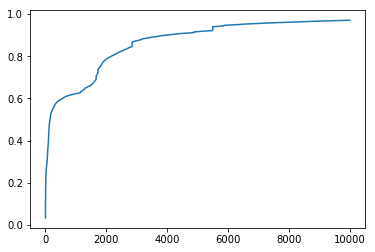

In [304]:
sorted_duplicate_cnt_by_step = np.array(list(sorted(duplicate_cnt_by_step.items(), key=lambda x: x[0])))
duplicates_by_step = np.cumsum(sorted_duplicate_cnt_by_step[:, 1])
duplicate_part_by_step = duplicates_by_step / total_half_duplicate_cnt
plt.plot(sorted_duplicate_cnt_by_step[:, 0], duplicate_part_by_step)
plt.show()

Выведем итоговую долю дубликатов

In [305]:
duplicate_part_by_step[-1]

0.9706873441479852

Выведем итерации, когда было получено 30% дублей, 50, 80 и 95

In [310]:
parts = [0.3, 0.5, 0.8, 0.95, 0.99]
parts_ind = 0
for step, duplicate_part in enumerate(duplicate_part_by_step):
    if duplicate_part >= parts[parts_ind]:
        persent = int(parts[parts_ind] * 100)
        print("{:5} steps are needed to get {}% of all duplicates".format(step, persent))
        parts_ind += 1
        if parts_ind == len(parts):
            break

   55 steps are needed to get 30% of all duplicates
  152 steps are needed to get 50% of all duplicates
 2166 steps are needed to get 80% of all duplicates
 6276 steps are needed to get 95% of all duplicates
